## Library

In [380]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from copy import copy
from scipy import stats

exec(open('library.py').read())
print('Loaded')

Loaded
Loaded


## Variables (customize these)

In [381]:
# Customize these!!!

# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 1000)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)
USE_NUMBERS = 'Peter'                             # Which variable set (see below) to use?
GRAPH_P = 50                                      # What percentile to graph on the graphs below? (default: 50)


# Variable sets - definitely change these!
if USE_NUMBERS == 'Ajeya':
    initial_gdp = 21 * trillion                    # GDP in `CURRENT_YEAR` of country that will develop TAI (default: 21.3 trillion)
    tai_flop_size = lognorm(27.58, 46.29)          # 90% CI, it takes 10^FLOPs to run a transformative AI at inference.
                                                   # Note: A petaflop/s-day (pfs-day) consists of performing 10^15 neural net operations per second for one day, or a total of about 10^20 operations
    algo_doubling_rate = norm(2.5, 2.5)            # 90% CI, algorithms get twice as efficient every X years
    min_reduction = norm(2, 2)                     # 90% CI, the minimum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    max_reduction = norm(5, 5)                     # 90% CI, the maximum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    initial_flops_per_dollar = norm(17.2, 17.2)    # 90% CI, as of today, we can buy 10^X FLOPs per $
    flops_halving_rate = norm(2.6, 3)              # 90% CI, the cost of FLOPs per $ halves every X years
    max_flops_per_dollar = norm(24, 24)            # 90% CI, the cheapest FLOPs will get is 10^X FLOPs per $
    initial_pay = norm(8.7, 8.7)                   # 90% CI, as of today the maximum we would pay for TAI is $10^X
    gdp_growth = norm(1.03, 1.03)                  # 90% CI, GDP will increase by a factor of X each year
    max_gdp_frac = norm(0.01, 0.01)                # 90% CI, the maximum % of GDP that would be spent on TAI is $10^X
    willingness_ramp = norm(1, 1)                  # 90% CI, if we are X% of the spend needed to acheive TAI, we will instantly jump to TAI
    spend_doubling_time = norm(2.5, 2.5)           # 90% CI, our willingness to spend on TAI doubles every X years
    initial_chance_of_nonscaling_issue = 0         # What is the chance there will be a non-scaling issue if TAI is feasible in `CURRENT_YEAR`?
    final_chance_of_nonscaling_issue = 0           # What is the chance there will be a non-scaling issue if TAI is feasible only by `nonscaling_issue_bottom_year` (see below)?
    nonscaling_issue_bottom_year = 0               # What year will will the chance of a non-scaling issue bottom out at (reaching `final_chance_of_nonscaling_issue`)?
    nonscaling_delay = norm(0, 0)                  # 90% CI, conditional on a delay, how many additional years will TAI be delayed due to issues unrelated to scaling to an adequate number of FLOPs (e.g., collecting the relevant training data)?
    base_p_recursive = 0                           # We assume the likelihood of seeing some recursive self-improvement loop increases as we get closer to TAI-level. What is the probability of such a loop at the max?
    recursive_curve_steepness = 0                  # How steep does the probability of recursive self-improvement increase with an increased amount of FLOP relative to the FLOP needed for TAI?
    recursive_curve_inflection = 0                 # How early in the ratio of FLOP present to FLOP needed for TAI does recursive self-improvement start (defining logistic curve)?
    p_recursive_creates_tai_instantly = 0          # If a recursive self-improvement loop is initiated, how likely is it to create full TAI within the year?
    recursive_flops_halving_rate_ = None           # If a recursive self-improvement loop is initiated, what does the FLOP halving rate become? (Assume now AI are potentially designing chips)
    recursive_algo_doubling_rate_ = None           # If a recursive self-improvement loop is initiated, what does the algorithm doubling rate become? (Assume now AI are potentially designing algorithms)
    recursive_spend_doubling_time = None           # If a recursive self-improvement loop is initiated, what does our spend doubling time become? (Assume now AIs can potntailly design profitable products) 
    recursive_gdp_growth_ = None                   # If a recursive self-improvement loop is initiated, what does our GDP growth rate become? (Assume now AIs can potntailly design profitable products)
    recursive_initial_chance_of_nonscaling_issue = None  # If a recursive self-improvement loop is initiated, what does `initial_chance_of_nonscaling_issue` become? (Assume now AIs can try to solve scaling issues)
    recursive_final_chance_of_nonscaling_issue = None    # If a recursive self-improvement loop is initiated, what does `final_chance_of_nonscaling_issue` become? (Assume now AIs can try to solve scaling issues)

elif USE_NUMBERS == 'Peter':
    initial_gdp = 21 * trillion
    tai_flop_size = lognorm(26, 46) # lognorm(22, 39)
    algo_doubling_rate = norm_lclip(1.5, 5) # norm_lclip(1, 3)
    min_reduction = norm(1, 3)
    max_reduction = norm(4, 8)
    initial_flops_per_dollar = norm(17, 17.5)
    flops_halving_rate = norm(2, 4) # norm_lclip(1, 3)
    max_flops_per_dollar = norm(22, 27)
    initial_pay = norm(7, 8)
    gdp_growth = norm(1.015, 1.03)
    max_gdp_frac = lognorm_lclip(0.0015, 0.02)
    willingness_ramp = norm(0.7, 1) # norm(0.1, 0.1)
    spend_doubling_time = lognorm_lclip(0.5, 3) # lognorm_lclip(0.5, 2)
    initial_chance_of_nonscaling_issue = 0.9 # 0
    final_chance_of_nonscaling_issue = 0.1 # 0
    nonscaling_issue_bottom_year = 2060
    nonscaling_delay = lognorm(1, 20)
    base_p_recursive = 0.5
    recursive_curve_steepness = 35
    recursive_curve_inflection = 0.1
    p_recursive_creates_tai_instantly = 0.05
    recursive_flops_halving_rate = lognorm_lclip(0.3, 2)
    recursive_algo_doubling_rate = lognorm_lclip(0.3, 2)
    recursive_spend_doubling_time = lognorm_lclip(0.3, 2)
    recursive_gdp_growth = lognorm_lclip(1.02, 1.1)
    recursive_initial_chance_of_nonscaling_issue = 0.2
    recursive_final_chance_of_nonscaling_issue = 0.01
    
else:
    raise ValueError


# These equations define how variables change over time or in relationship to other variables.
def gdp(initial_gdp, gdp_growth, year):
    return initial_gdp * (gdp_growth ** year)

def willingness_to_pay(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac, year):
    gdp_ = gdp(initial_gdp=initial_gdp, gdp_growth=gdp_growth, year=year)
    x = (np.log(2) / spend_doubling_time) * year
    if x < 709:
        return 10 ** (math.log10(initial_pay) + math.log10(math.exp(x)) - math.log10(1 + initial_pay / (gdp_ * max_gdp_frac) * math.exp(x)))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_pay) + (year/spend_doubling_time)/3.3)

def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)

def flops_needed(initial_flops, possible_reduction, doubling_rate, year):
    x = (np.log(2) / doubling_rate) * year
    if x < 709:
        return 10 ** (math.log10(initial_flops) - max(math.log10(math.exp(x)) - math.log10(1 + (1/possible_reduction) * math.exp(x)), 0))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops) - (1/possible_reduction))

def flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, halving_rate, year):
    x = (np.log(2) / halving_rate) * year
    if x < 709:
        return 10 ** (math.log10(initial_flops_per_dollar) + math.log10(math.exp(x)) - math.log10(1 + initial_flops_per_dollar / max_flops_per_dollar * math.exp(x)))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops_per_dollar) + (year/halving_rate)/3.3)

def cost_of_tai(initial_flops, possible_reduction, algo_doubling_rate, initial_flops_per_dollar, max_flops_per_dollar,
                flops_halving_rate, year):
    return (flops_needed(initial_flops, possible_reduction, algo_doubling_rate, year) /
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))

def flops_at_max(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac,
                 initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year):
    return (willingness_to_pay(initial_gdp=initial_gdp,
                               gdp_growth=gdp_growth,
                               initial_pay=initial_pay,
                               spend_doubling_time=spend_doubling_time,
                               max_gdp_frac=0.01,
                               year=year) *
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))

def p_nonscaling_delay(initial_p, final_p, year, max_year):
    initial_p = initial_p - final_p
    p_ = initial_p - (initial_p * ((year - CURRENT_YEAR) / (max_year - CURRENT_YEAR))) + final_p
    return final_p if p_ < final_p else p_

def p_rapid_recursive_self_improvement(flops_needed_for_tai, flops_we_have, base_p, curve_steepness, curve_inflection):
    if flops_we_have > 10 ** 250:
        return base_p  # Handle overflow error
    else:
        ratio = flops_we_have / flops_needed_for_tai
        return base_p / (1 + math.exp(-curve_steepness * (ratio - curve_inflection)))

    
# ------------- Ignore below here ------------
years = list(range(CURRENT_YEAR, MAX_YEAR))
print('Loaded')


Loaded


In [382]:
initial_flops_p = get_percentiles([sample(tai_flop_size) for s in range(1000)], reverse=True)
initial_flops_p

{95: 25.585621332958763,
 90: 27.410877988249375,
 80: 29.608548073518683,
 70: 31.374791839990927,
 60: 32.81877073522302,
 50: 34.27897873107341,
 40: 36.051119112549216,
 30: 37.720796239805836,
 20: 40.07539158915438,
 10: 43.165724963541095,
 5: 46.322754729928874}

In [383]:
min_reduction_p = get_percentiles([sample(min_reduction) for s in range(1000)], reverse=True)
min_reduction_p

{95: 1.0569070306943114,
 90: 1.2763659112937895,
 80: 1.5104627356685723,
 70: 1.7071575389773612,
 60: 1.8667114423270137,
 50: 1.9986367843893298,
 40: 2.1477470977211395,
 30: 2.2809532143821207,
 20: 2.4665120987166573,
 10: 2.6983728668958067,
 5: 2.9478053822096095}

In [384]:
max_reduction_p = get_percentiles([sample(max_reduction) for s in range(1000)], reverse=True)
max_reduction_p

{95: 4.020742993558505,
 90: 4.485708829599599,
 80: 4.981128275008123,
 70: 5.354599701238298,
 60: 5.703401898615139,
 50: 6.075463209844134,
 40: 6.343957637408348,
 30: 6.636078331185431,
 20: 7.0760350710477375,
 10: 7.501930890120727,
 5: 7.906587177775665}

In [385]:
algo_doubling_rate_p = get_percentiles([sample(algo_doubling_rate) for s in range(1000)], reverse=True)
algo_doubling_rate_p

{95: 1.5,
 90: 1.825865677336256,
 80: 2.3618699475041804,
 70: 2.665303882966091,
 60: 2.933893365530559,
 50: 3.2242789412518498,
 40: 3.4497762481788756,
 30: 3.7505040028249654,
 20: 4.123186897429809,
 10: 4.544161147024452,
 5: 4.9618896738883915}

In [386]:
initial_flops_per_dollar_p = get_percentiles([sample(initial_flops_per_dollar) for s in range(1000)])
initial_flops_per_dollar_p

{5: 17.00718458839897,
 10: 17.06250768945357,
 20: 17.13212013061699,
 30: 17.178198994713895,
 40: 17.222481907829735,
 50: 17.255808781432755,
 60: 17.2870530780868,
 70: 17.330329760468686,
 80: 17.371831318990004,
 90: 17.433949731149408,
 95: 17.49596422525336}

In [387]:
flops_halving_rate_p = get_percentiles([sample(flops_halving_rate) for s in range(1000)], reverse=True)
flops_halving_rate_p

{95: 2.0182036495255455,
 90: 2.2288290150304975,
 80: 2.491609329273224,
 70: 2.704147761058981,
 60: 2.8520191519139413,
 50: 2.98610822939194,
 40: 3.1372477111941173,
 30: 3.308858174750475,
 20: 3.5037820046445964,
 10: 3.7328506859304955,
 5: 4.042133984040042}

In [388]:
max_flops_per_dollar_p = get_percentiles([sample(max_flops_per_dollar) for s in range(1000)])
max_flops_per_dollar_p

{5: 22.235802300791622,
 10: 22.697128799249075,
 20: 23.294118254765085,
 30: 23.7943343730614,
 40: 24.14807962363657,
 50: 24.518142334364654,
 60: 24.93996110577625,
 70: 25.405102855214963,
 80: 25.91885834863302,
 90: 26.59569836231678,
 95: 27.137034782435205}

In [389]:
initial_pay_p = get_percentiles([sample(initial_pay) for s in range(1000)])
initial_pay_p

{5: 7.02208635957576,
 10: 7.1197316634507555,
 20: 7.247158869566088,
 30: 7.354396233902344,
 40: 7.422060798616947,
 50: 7.497713250080611,
 60: 7.574709914362675,
 70: 7.6637372635082635,
 80: 7.7536287702118365,
 90: 7.867407014096035,
 95: 7.958144070694669}

In [390]:
gdp_growth_p = get_percentiles([sample(gdp_growth) for s in range(1000)])
gdp_growth_p

{5: 1.0152977999028197,
 10: 1.016491633872248,
 20: 1.018558848048233,
 30: 1.01992693871252,
 40: 1.0213948784383877,
 50: 1.022485625837604,
 60: 1.0235688483202252,
 70: 1.0247170095001992,
 80: 1.0262770018656298,
 90: 1.0285062135617518,
 95: 1.0300496996123338}

In [391]:
max_gdp_frac_p = get_percentiles([sample(max_gdp_frac) for s in range(1000)])
max_gdp_frac_p

{5: 0.0015462366314711014,
 10: 0.0019947187034913935,
 20: 0.00284317337773179,
 30: 0.0035609896994766173,
 40: 0.004291979530800549,
 50: 0.005121108858852412,
 60: 0.006288728543382104,
 70: 0.008004396980256128,
 80: 0.010295788919171794,
 90: 0.014554735089254405,
 95: 0.018642797105428918}

In [392]:
willingness_ramp_p = get_percentiles([sample(willingness_ramp) for s in range(1000)])
willingness_ramp_p

{5: 0.7044931811871765,
 10: 0.7319328169412295,
 20: 0.7694626189482119,
 30: 0.7956007856820606,
 40: 0.8257570727328102,
 50: 0.8517935977951164,
 60: 0.8733048029490399,
 70: 0.8971885701465625,
 80: 0.9312012549986797,
 90: 0.9728996741910015,
 95: 1.0000356104543067}

In [393]:
spend_doubling_time_p = get_percentiles([sample(spend_doubling_time) for s in range(1000)], reverse=True)
spend_doubling_time_p

{95: 0.5,
 90: 0.6071921984839441,
 80: 0.7736539103419222,
 70: 0.9022355689549149,
 60: 1.0328266890510933,
 50: 1.1916453891611465,
 40: 1.385938367502321,
 30: 1.5941357749962666,
 20: 1.8877163564846928,
 10: 2.386034225077707,
 5: 2.840524104724006}

In [394]:
nonscaling_delay_p = get_percentiles([sample(nonscaling_delay) for s in range(1000)], reverse=True)
nonscaling_delay_p

{95: 1.0630174393152045,
 90: 1.4507009550459755,
 80: 2.028426537657826,
 70: 2.7559627863004414,
 60: 3.5828909407950107,
 50: 4.648514842610265,
 40: 5.646617608529269,
 30: 7.3924538659808565,
 20: 9.567559863068901,
 10: 14.614397288965659,
 5: 20.448933680943952}

In [395]:
if recursive_flops_halving_rate:
    recursive_flops_halving_rate_ = get_percentiles([sample(recursive_flops_halving_rate) for s in range(1000)])
    print(recursive_flops_halving_rate_)
else:
    print('N/A')


{5: 0.3, 10: 0.3636577944612904, 20: 0.47204516360343224, 30: 0.5818332420294533, 40: 0.6746142857664839, 50: 0.7937677468282673, 60: 0.9278276042708067, 70: 1.0651013152079383, 80: 1.317980767255456, 90: 1.7347474706972918, 95: 2.048126419941809}


In [396]:
if recursive_algo_doubling_rate:
    recursive_algo_doubling_rate_ = get_percentiles([sample(recursive_algo_doubling_rate) for s in range(1000)])
    print(recursive_algo_doubling_rate_)
else:
    print('N/A')
    

{5: 0.3016437553769042, 10: 0.3726382499722696, 20: 0.4748812944835518, 30: 0.5684059603794029, 40: 0.6636752123896694, 50: 0.77722067530925, 60: 0.8836563211193711, 70: 1.0324831199840112, 80: 1.2736361130678577, 90: 1.6182355089051845, 95: 2.0555930734180548}


In [397]:
if recursive_spend_doubling_time:
    recursive_spend_doubling_time_ = get_percentiles([sample(recursive_spend_doubling_time) for s in range(1000)])
    print(recursive_spend_doubling_time_)
else:
    print('N/A')


{5: 0.3039371209938774, 10: 0.3635860924767895, 20: 0.4789376643758711, 30: 0.5772346264763915, 40: 0.6780399166140205, 50: 0.7675571118096058, 60: 0.9034247110975773, 70: 1.0406003293532182, 80: 1.2281854904547318, 90: 1.6067951052450289, 95: 2.0858201967577785}


In [398]:
if recursive_gdp_growth:
    recursive_gdp_growth_ = get_percentiles([sample(recursive_gdp_growth) for s in range(1000)])
    print(recursive_gdp_growth_)
else:
    print('N/A')
    

{5: 1.02, 10: 1.0274844961672467, 20: 1.0375977777550276, 30: 1.0464390903610292, 40: 1.0528298398266545, 50: 1.0597078054073361, 60: 1.0667247865813345, 70: 1.0727707115525664, 80: 1.080582702999099, 90: 1.0916820197800547, 95: 1.10115151465758}


## GDP Over Time

Text(0, 0.5, 'log GDP')

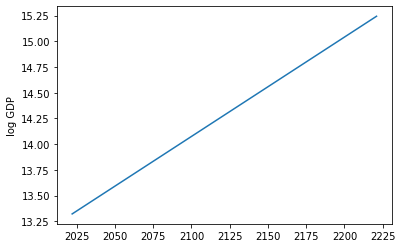

In [399]:
gdp_ = np.array([gdp(initial_gdp=initial_gdp,
                     gdp_growth=gdp_growth_p[GRAPH_P],
                     year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(gdp_))
plt.ylabel('log GDP')

In [400]:
for y in years:
    print('Year: {} - GDP log$ {} ({})'.format(y,
                                               np.round(np.log10(gdp_[y - CURRENT_YEAR]), 1),
                                               numerize(np.log10(gdp_[y - CURRENT_YEAR]))))
    

Year: 2022 - GDP log$ 13.3 (10 trillion)
Year: 2023 - GDP log$ 13.3 (10 trillion)
Year: 2024 - GDP log$ 13.3 (10 trillion)
Year: 2025 - GDP log$ 13.4 (10 trillion)
Year: 2026 - GDP log$ 13.4 (10 trillion)
Year: 2027 - GDP log$ 13.4 (10 trillion)
Year: 2028 - GDP log$ 13.4 (10 trillion)
Year: 2029 - GDP log$ 13.4 (10 trillion)
Year: 2030 - GDP log$ 13.4 (10 trillion)
Year: 2031 - GDP log$ 13.4 (10 trillion)
Year: 2032 - GDP log$ 13.4 (10 trillion)
Year: 2033 - GDP log$ 13.4 (10 trillion)
Year: 2034 - GDP log$ 13.4 (10 trillion)
Year: 2035 - GDP log$ 13.4 (10 trillion)
Year: 2036 - GDP log$ 13.5 (10 trillion)
Year: 2037 - GDP log$ 13.5 (10 trillion)
Year: 2038 - GDP log$ 13.5 (10 trillion)
Year: 2039 - GDP log$ 13.5 (10 trillion)
Year: 2040 - GDP log$ 13.5 (10 trillion)
Year: 2041 - GDP log$ 13.5 (10 trillion)
Year: 2042 - GDP log$ 13.5 (10 trillion)
Year: 2043 - GDP log$ 13.5 (10 trillion)
Year: 2044 - GDP log$ 13.5 (10 trillion)
Year: 2045 - GDP log$ 13.5 (10 trillion)
Year: 2046 - GDP

## Willingness to Pay Over Time

Text(0, 0.5, 'log $ willing to spend on TAI')

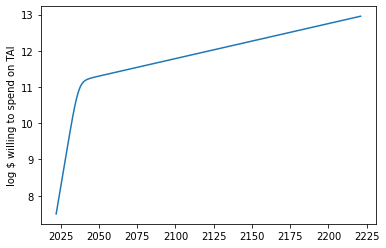

In [401]:
willingness = np.array([willingness_to_pay(initial_gdp=initial_gdp,
                                           gdp_growth=gdp_growth_p[GRAPH_P],
                                           initial_pay=10 ** initial_pay_p[GRAPH_P],
                                           spend_doubling_time=spend_doubling_time_p[GRAPH_P],
                                           max_gdp_frac=max_gdp_frac_p[GRAPH_P],
                                           year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(willingness))
plt.ylabel('log $ willing to spend on TAI')


In [402]:
for y in years:
    print('Year: {} - willingness log$ {} ({})'.format(y,
                                                       np.round(np.log10(willingness[y - CURRENT_YEAR]), 1),
                                                       numerize(np.log10(willingness[y - CURRENT_YEAR]))))

Year: 2022 - willingness log$ 7.5 (10 million)
Year: 2023 - willingness log$ 7.8 (10 million)
Year: 2024 - willingness log$ 8.0 (100 million)
Year: 2025 - willingness log$ 8.3 (100 million)
Year: 2026 - willingness log$ 8.5 (100 million)
Year: 2027 - willingness log$ 8.8 (100 million)
Year: 2028 - willingness log$ 9.0 (one billion)
Year: 2029 - willingness log$ 9.3 (one billion)
Year: 2030 - willingness log$ 9.5 (one billion)
Year: 2031 - willingness log$ 9.8 (one billion)
Year: 2032 - willingness log$ 10.0 (one billion)
Year: 2033 - willingness log$ 10.2 (10 billion)
Year: 2034 - willingness log$ 10.4 (10 billion)
Year: 2035 - willingness log$ 10.6 (10 billion)
Year: 2036 - willingness log$ 10.8 (10 billion)
Year: 2037 - willingness log$ 10.9 (10 billion)
Year: 2038 - willingness log$ 11.0 (100 billion)
Year: 2039 - willingness log$ 11.1 (100 billion)
Year: 2040 - willingness log$ 11.1 (100 billion)
Year: 2041 - willingness log$ 11.2 (100 billion)
Year: 2042 - willingness log$ 11.2 (1

## FLOPs Needed to Make TAI (Given Algorithmic Progress)

Text(0, 0.5, 'log FLOPs needed to make TAI')

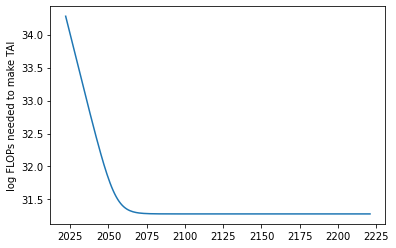

In [403]:
flops_ = np.array([flops_needed(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                doubling_rate=algo_doubling_rate_p[GRAPH_P],
                                possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_))
plt.ylabel('log FLOPs needed to make TAI')


In [404]:
for y in years:
    print('Year: {} - log FLOPs needed for TAI {} ({})'.format(y,
                                                               np.round(np.log10(flops_[y - CURRENT_YEAR]), 1),
                                                               numerize(np.log10(flops_[y - CURRENT_YEAR]))))

Year: 2022 - log FLOPs needed for TAI 34.3 (10 decillion)
Year: 2023 - log FLOPs needed for TAI 34.2 (10 decillion)
Year: 2024 - log FLOPs needed for TAI 34.1 (10 decillion)
Year: 2025 - log FLOPs needed for TAI 34.0 (one decillion)
Year: 2026 - log FLOPs needed for TAI 33.9 (one decillion)
Year: 2027 - log FLOPs needed for TAI 33.8 (one decillion)
Year: 2028 - log FLOPs needed for TAI 33.7 (one decillion)
Year: 2029 - log FLOPs needed for TAI 33.6 (one decillion)
Year: 2030 - log FLOPs needed for TAI 33.5 (one decillion)
Year: 2031 - log FLOPs needed for TAI 33.4 (one decillion)
Year: 2032 - log FLOPs needed for TAI 33.3 (one decillion)
Year: 2033 - log FLOPs needed for TAI 33.3 (one decillion)
Year: 2034 - log FLOPs needed for TAI 33.2 (one decillion)
Year: 2035 - log FLOPs needed for TAI 33.1 (one decillion)
Year: 2036 - log FLOPs needed for TAI 33.0 (100 nonillion)
Year: 2037 - log FLOPs needed for TAI 32.9 (100 nonillion)
Year: 2038 - log FLOPs needed for TAI 32.8 (100 nonillion)


## FLOPs per Dollar (Given Declining Costs)

Text(0, 0.5, 'log FLOPs per $1')

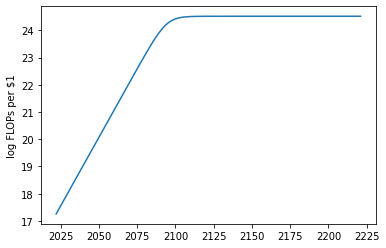

In [405]:
flops_per_dollar_ = np.array([flops_per_dollar(initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                               max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                               halving_rate=flops_halving_rate_p[GRAPH_P],
                                               year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(flops_per_dollar_))
plt.ylabel('log FLOPs per $1')


In [406]:
for y in years:
    print('Year: {} - log {} FLOPs per $ ({})'.format(y,
                                                      np.round(np.log10(flops_per_dollar_[y - CURRENT_YEAR]), 1),
                                                      numerize(np.log10(flops_per_dollar_[y - CURRENT_YEAR]))))

Year: 2022 - log 17.3 FLOPs per $ (100 quadrillion)
Year: 2023 - log 17.4 FLOPs per $ (100 quadrillion)
Year: 2024 - log 17.5 FLOPs per $ (100 quadrillion)
Year: 2025 - log 17.6 FLOPs per $ (100 quadrillion)
Year: 2026 - log 17.7 FLOPs per $ (100 quadrillion)
Year: 2027 - log 17.8 FLOPs per $ (100 quadrillion)
Year: 2028 - log 17.9 FLOPs per $ (100 quadrillion)
Year: 2029 - log 18.0 FLOPs per $ (100 quadrillion)
Year: 2030 - log 18.1 FLOPs per $ (one quintillion)
Year: 2031 - log 18.2 FLOPs per $ (one quintillion)
Year: 2032 - log 18.3 FLOPs per $ (one quintillion)
Year: 2033 - log 18.4 FLOPs per $ (one quintillion)
Year: 2034 - log 18.5 FLOPs per $ (one quintillion)
Year: 2035 - log 18.6 FLOPs per $ (one quintillion)
Year: 2036 - log 18.7 FLOPs per $ (one quintillion)
Year: 2037 - log 18.8 FLOPs per $ (one quintillion)
Year: 2038 - log 18.9 FLOPs per $ (one quintillion)
Year: 2039 - log 19.0 FLOPs per $ (one quintillion)
Year: 2040 - log 19.1 FLOPs per $ (10 quintillion)
Year: 2041 - 

## Max Possible OOM Reduction in TAI FLOP Size

Text(0.5, 0, 'initial FLOP needed for TAI prior to any reduction')

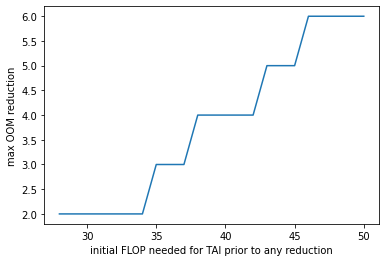

In [407]:
tai_sizes = range(28, 51)
flops_per_dollar_ = np.array([possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], t) for t in tai_sizes])
plt.plot(tai_sizes, flops_per_dollar_)
plt.ylabel('max OOM reduction')
plt.xlabel('initial FLOP needed for TAI prior to any reduction')

In [408]:
for t in tai_sizes:
    print('TAI log FLOP {} -> {} OOM reductions possible'.format(t,
                                                                 round(possible_algo_reduction_fn(min_reduction_p[GRAPH_P],
                                                                                                  max_reduction_p[GRAPH_P],
                                                                                                  t), 2)))
          

TAI log FLOP 28 -> 2.0 OOM reductions possible
TAI log FLOP 29 -> 2.0 OOM reductions possible
TAI log FLOP 30 -> 2.0 OOM reductions possible
TAI log FLOP 31 -> 2.0 OOM reductions possible
TAI log FLOP 32 -> 2.0 OOM reductions possible
TAI log FLOP 33 -> 2.0 OOM reductions possible
TAI log FLOP 34 -> 2.0 OOM reductions possible
TAI log FLOP 35 -> 3.0 OOM reductions possible
TAI log FLOP 36 -> 3.0 OOM reductions possible
TAI log FLOP 37 -> 3.0 OOM reductions possible
TAI log FLOP 38 -> 4.0 OOM reductions possible
TAI log FLOP 39 -> 4.0 OOM reductions possible
TAI log FLOP 40 -> 4.0 OOM reductions possible
TAI log FLOP 41 -> 4.0 OOM reductions possible
TAI log FLOP 42 -> 4.0 OOM reductions possible
TAI log FLOP 43 -> 5.0 OOM reductions possible
TAI log FLOP 44 -> 5.0 OOM reductions possible
TAI log FLOP 45 -> 5.0 OOM reductions possible
TAI log FLOP 46 -> 6.0 OOM reductions possible
TAI log FLOP 47 -> 6.0 OOM reductions possible
TAI log FLOP 48 -> 6.0 OOM reductions possible
TAI log FLOP 

## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP)

Text(0, 0.5, 'log $ needed to buy TAI')

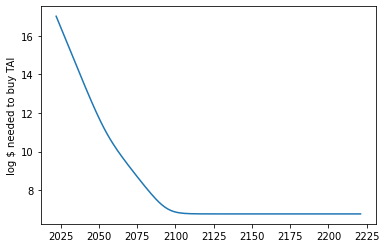

In [409]:
cost_of_tai_ = np.array([cost_of_tai(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                     possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                     algo_doubling_rate=algo_doubling_rate_p[GRAPH_P],
                                     initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                     max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                     flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                     year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(cost_of_tai_))
plt.ylabel('log $ needed to buy TAI')


In [410]:
for y in years:
    print('Year: {} - log $ {} to buy TAI ({})'.format(y,
                                                       np.round(np.log10(cost_of_tai_[y - CURRENT_YEAR]), 1),
                                                       numerize(np.log10(cost_of_tai_[y - CURRENT_YEAR]))))

Year: 2022 - log $ 17.0 to buy TAI (100 quadrillion)
Year: 2023 - log $ 16.8 to buy TAI (10 quadrillion)
Year: 2024 - log $ 16.6 to buy TAI (10 quadrillion)
Year: 2025 - log $ 16.4 to buy TAI (10 quadrillion)
Year: 2026 - log $ 16.2 to buy TAI (10 quadrillion)
Year: 2027 - log $ 16.1 to buy TAI (10 quadrillion)
Year: 2028 - log $ 15.9 to buy TAI (one quadrillion)
Year: 2029 - log $ 15.7 to buy TAI (one quadrillion)
Year: 2030 - log $ 15.5 to buy TAI (one quadrillion)
Year: 2031 - log $ 15.3 to buy TAI (one quadrillion)
Year: 2032 - log $ 15.1 to buy TAI (one quadrillion)
Year: 2033 - log $ 14.9 to buy TAI (100 trillion)
Year: 2034 - log $ 14.7 to buy TAI (100 trillion)
Year: 2035 - log $ 14.5 to buy TAI (100 trillion)
Year: 2036 - log $ 14.3 to buy TAI (100 trillion)
Year: 2037 - log $ 14.1 to buy TAI (100 trillion)
Year: 2038 - log $ 13.9 to buy TAI (10 trillion)
Year: 2039 - log $ 13.7 to buy TAI (10 trillion)
Year: 2040 - log $ 13.5 to buy TAI (10 trillion)
Year: 2041 - log $ 13.4 t

## FLOPs at Max Spend

Text(0, 0.5, 'max log FLOPs bought given willingness to spend')

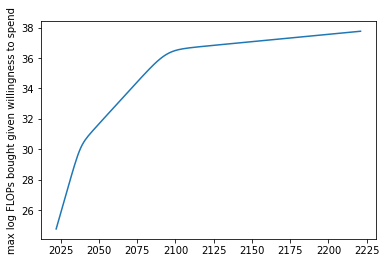

In [411]:
flops_at_max_ = np.array([flops_at_max(initial_gdp=initial_gdp,
                                       gdp_growth=gdp_growth_p[GRAPH_P],
                                       initial_pay=10 ** initial_pay_p[GRAPH_P],
                                       spend_doubling_time=spend_doubling_time_p[GRAPH_P],
                                       max_gdp_frac=max_gdp_frac_p[GRAPH_P],
                                       initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                       max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                       flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                       year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_at_max_))
plt.ylabel('max log FLOPs bought given willingness to spend')


In [412]:
for y in years:
    print('Year: {} - max log FLOPs {} ({})'.format(y,
                                                    np.round(np.log10(flops_at_max_[y - CURRENT_YEAR]), 1),
                                                    numerize(np.log10(flops_at_max_[y - CURRENT_YEAR]))))

Year: 2022 - max log FLOPs 24.8 (one septillion)
Year: 2023 - max log FLOPs 25.1 (10 septillion)
Year: 2024 - max log FLOPs 25.5 (10 septillion)
Year: 2025 - max log FLOPs 25.8 (10 septillion)
Year: 2026 - max log FLOPs 26.2 (100 septillion)
Year: 2027 - max log FLOPs 26.5 (100 septillion)
Year: 2028 - max log FLOPs 26.9 (100 septillion)
Year: 2029 - max log FLOPs 27.2 (one octillion)
Year: 2030 - max log FLOPs 27.6 (one octillion)
Year: 2031 - max log FLOPs 27.9 (one octillion)
Year: 2032 - max log FLOPs 28.3 (10 octillion)
Year: 2033 - max log FLOPs 28.6 (10 octillion)
Year: 2034 - max log FLOPs 28.9 (10 octillion)
Year: 2035 - max log FLOPs 29.3 (100 octillion)
Year: 2036 - max log FLOPs 29.6 (100 octillion)
Year: 2037 - max log FLOPs 29.8 (100 octillion)
Year: 2038 - max log FLOPs 30.1 (one nonillion)
Year: 2039 - max log FLOPs 30.3 (one nonillion)
Year: 2040 - max log FLOPs 30.5 (one nonillion)
Year: 2041 - max log FLOPs 30.6 (one nonillion)
Year: 2042 - max log FLOPs 30.7 (one no

## Chance of Non-scaling Delay

Text(0, 0.5, 'chance of non-scaling delay by year')

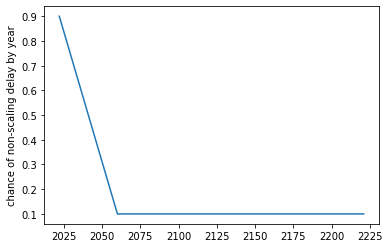

In [413]:
p_nonscaling_delay_ = np.array([p_nonscaling_delay(initial_chance_of_nonscaling_issue,
                                                   final_chance_of_nonscaling_issue,
                                                   year=y,
                                                   max_year=nonscaling_issue_bottom_year) for y in years])

plt.plot(years, p_nonscaling_delay_)
plt.ylabel('chance of non-scaling delay by year')
# TODO: Make logistic?

In [414]:
for y in years:
    print('Year: {} - p(nonscaling delay) = {}%'.format(y,
                                                        np.round(p_nonscaling_delay_[y - CURRENT_YEAR] * 100, 1)))

Year: 2022 - p(nonscaling delay) = 90.0%
Year: 2023 - p(nonscaling delay) = 87.9%
Year: 2024 - p(nonscaling delay) = 85.8%
Year: 2025 - p(nonscaling delay) = 83.7%
Year: 2026 - p(nonscaling delay) = 81.6%
Year: 2027 - p(nonscaling delay) = 79.5%
Year: 2028 - p(nonscaling delay) = 77.4%
Year: 2029 - p(nonscaling delay) = 75.3%
Year: 2030 - p(nonscaling delay) = 73.2%
Year: 2031 - p(nonscaling delay) = 71.1%
Year: 2032 - p(nonscaling delay) = 68.9%
Year: 2033 - p(nonscaling delay) = 66.8%
Year: 2034 - p(nonscaling delay) = 64.7%
Year: 2035 - p(nonscaling delay) = 62.6%
Year: 2036 - p(nonscaling delay) = 60.5%
Year: 2037 - p(nonscaling delay) = 58.4%
Year: 2038 - p(nonscaling delay) = 56.3%
Year: 2039 - p(nonscaling delay) = 54.2%
Year: 2040 - p(nonscaling delay) = 52.1%
Year: 2041 - p(nonscaling delay) = 50.0%
Year: 2042 - p(nonscaling delay) = 47.9%
Year: 2043 - p(nonscaling delay) = 45.8%
Year: 2044 - p(nonscaling delay) = 43.7%
Year: 2045 - p(nonscaling delay) = 41.6%
Year: 2046 - p(n

## Chance of Rapid Recursive Self-Improvement

Text(0.5, 0, 'percentage of TAI-level FLOP')

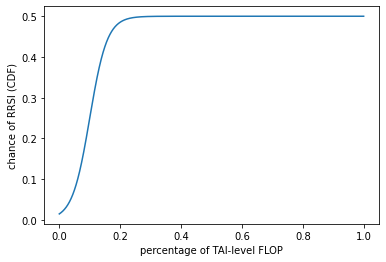

In [415]:
p_rrsi_ = np.array([p_rapid_recursive_self_improvement(10000,
                                                       x,
                                                       base_p_recursive,
                                                       recursive_curve_steepness,
                                                       recursive_curve_inflection) for x in range(10000)])

plt.plot([r / 10000 for r in range(10000)], p_rrsi_)
plt.ylabel('chance of RRSI (CDF)')
plt.xlabel('percentage of TAI-level FLOP')

In [416]:
samples = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200,
           1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
for i in samples:
    print('Ratio: {} in 10000 - p(RRSI) (CDF) = {}%'.format(i, np.round(p_rrsi_[i-1] * 100, 1)))

Ratio: 1 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 5 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 10 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 20 in 10000 - p(RRSI) (CDF) = 1.6%
Ratio: 30 in 10000 - p(RRSI) (CDF) = 1.6%
Ratio: 40 in 10000 - p(RRSI) (CDF) = 1.7%
Ratio: 50 in 10000 - p(RRSI) (CDF) = 1.7%
Ratio: 60 in 10000 - p(RRSI) (CDF) = 1.8%
Ratio: 70 in 10000 - p(RRSI) (CDF) = 1.9%
Ratio: 80 in 10000 - p(RRSI) (CDF) = 1.9%
Ratio: 90 in 10000 - p(RRSI) (CDF) = 2.0%
Ratio: 100 in 10000 - p(RRSI) (CDF) = 2.0%
Ratio: 200 in 10000 - p(RRSI) (CDF) = 2.9%
Ratio: 300 in 10000 - p(RRSI) (CDF) = 4.0%
Ratio: 400 in 10000 - p(RRSI) (CDF) = 5.4%
Ratio: 500 in 10000 - p(RRSI) (CDF) = 7.4%
Ratio: 600 in 10000 - p(RRSI) (CDF) = 9.9%
Ratio: 700 in 10000 - p(RRSI) (CDF) = 12.9%
Ratio: 800 in 10000 - p(RRSI) (CDF) = 16.6%
Ratio: 900 in 10000 - p(RRSI) (CDF) = 20.6%
Ratio: 1000 in 10000 - p(RRSI) (CDF) = 25.0%
Ratio: 1100 in 10000 - p(RRSI) (CDF) = 29.3%
Ratio: 1200 in 10000 - p(RRSI) (CDF) = 33.4%
Ratio: 1300 in 

## Run Model

Running
## RUN 1/10000 ##
Diagnostic: tai_flop_size=31.45899097689335, nonscaling_delay=10.201007269173282, algo_doubling_rate=2.581005828970669, possible_algo_reduction=2.313441074085736, initial_flops_per_dollar=2.5895609194869725e+17, flops_halving_rate=2.2881960151163874, max_flops_per_dollar=1.2895470027330448e+23, initial_pay=31293717.48594196, gdp_growth=1.0189470428476444, max_gdp_frac=0.02277512242831556, willingness_ramp=0.8099436356330452, spend_doubling_time=1.024871255644817
-
It takes 31.5 log FLOPs (10 nonillion) for transformative capabilities.
Every 2.6 years algorithms get 2x better, with 2.3 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 2.3 years they get 2x cheaper, to a maximum of 23.1 log FLOPs (100 sextillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 1.0x per year to a max of 0.0228% of GDP. GDP grows at a rate of 1.019x per year.
If we are 81.0% of the way to paying for TAI, we wi

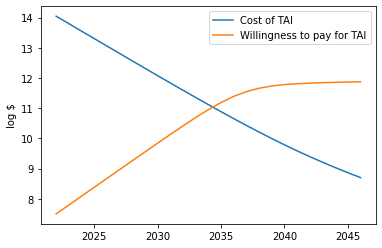

## RUN 2/10000 ##
Diagnostic: tai_flop_size=32.67093104547785, nonscaling_delay=0.9281932559106362, algo_doubling_rate=2.536371826532874, possible_algo_reduction=1.3491580498107452, initial_flops_per_dollar=1.2934448814071808e+17, flops_halving_rate=3.262918860347014, max_flops_per_dollar=1.4825969690694478e+23, initial_pay=123104163.56717968, gdp_growth=1.0245062080966059, max_gdp_frac=0.008649627140430277, willingness_ramp=0.8596142360549331, spend_doubling_time=0.8504397025586873
-
It takes 32.7 log FLOPs (100 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 1.3 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 3.3 years they get 2x cheaper, to a maximum of 23.2 log FLOPs (100 sextillion) per $.
We are willing to pay 8.1 log $ (100 million) and this increases by 0.9x per year to a max of 0.0086% of GDP. GDP grows at a rate of 1.025x per year.
If we are 86.0% of the way to paying for TAI, we will 

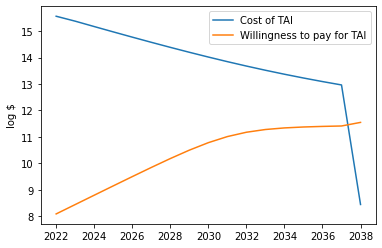

## RUN 3/10000 ##
Diagnostic: tai_flop_size=33.88617267480143, nonscaling_delay=3.2209187627950304, algo_doubling_rate=2.2715826055387547, possible_algo_reduction=1.409862121155764, initial_flops_per_dollar=1.716478135129309e+17, flops_halving_rate=1.9535112912887185, max_flops_per_dollar=7.673347275722522e+22, initial_pay=21371028.940916758, gdp_growth=1.0246301686280839, max_gdp_frac=0.005780765458206974, willingness_ramp=0.8495121796630346, spend_doubling_time=0.7340180782937763
-
It takes 33.9 log FLOPs (one decillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 1.4 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.0 years they get 2x cheaper, to a maximum of 22.9 log FLOPs (10 sextillion) per $.
We are willing to pay 7.3 log $ (10 million) and this increases by 0.7x per year to a max of 0.0058% of GDP. GDP grows at a rate of 1.025x per year.
If we are 85.0% of the way to paying for TAI, we will ram

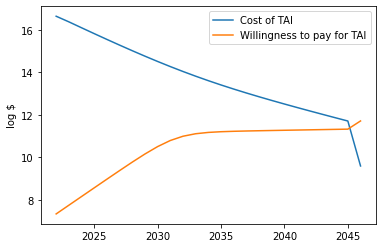

## RUN 4/10000 ##
Diagnostic: tai_flop_size=36.081580930996275, nonscaling_delay=13.81099464189775, algo_doubling_rate=3.3785875029442254, possible_algo_reduction=2.204471012822609, initial_flops_per_dollar=1.2347467084898278e+17, flops_halving_rate=2.9532617083158246, max_flops_per_dollar=7.723105294788467e+25, initial_pay=33190777.973460592, gdp_growth=1.024431779900923, max_gdp_frac=0.0015, willingness_ramp=0.6877552361490767, spend_doubling_time=0.5
-
It takes 36.1 log FLOPs (one thousand decillion) for transformative capabilities.
Every 3.4 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 3.0 years they get 2x cheaper, to a maximum of 25.9 log FLOPs (10 septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.5x per year to a max of 0.0015% of GDP. GDP grows at a rate of 1.024x per year.
If we are 69.0% of the way to paying for TAI, we will ramp to paying for TAI.

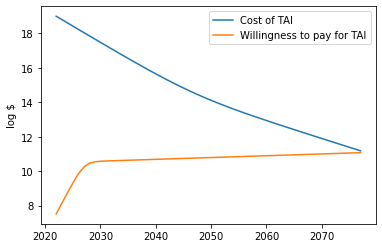

## RUN 5/10000 ##
Diagnostic: tai_flop_size=41.834882357740604, nonscaling_delay=7.047199335024774, algo_doubling_rate=4.429591968319954, possible_algo_reduction=4.547208796913914, initial_flops_per_dollar=1.5097792398418794e+17, flops_halving_rate=2.254849937132616, max_flops_per_dollar=2.5336437522989314e+24, initial_pay=24619344.30640289, gdp_growth=1.0275800746048764, max_gdp_frac=0.004814502020852615, willingness_ramp=0.9514993832764578, spend_doubling_time=0.6029502443564926
-
It takes 41.8 log FLOPs (100 million decillion) for transformative capabilities.
Every 4.4 years algorithms get 2x better, with 4.5 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.3 years they get 2x cheaper, to a maximum of 24.4 log FLOPs (one septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 0.6x per year to a max of 0.0048% of GDP. GDP grows at a rate of 1.028x per year.
If we are 95.0% of the way to paying for TAI, we 

Year: 2052 - 32.5 max log FLOP (100 nonillion) available - TAI takes 39.8 log FLOP (one million decillion) - log $ 18.6 to buy TAI (one quintillion) vs. willingness to pay log $ 11.4 (100 billion) - 21.2 log FLOPS per $ (one sextillion)
--- no rapid recursive loop (ratio=0.0, p=0.0018320178862006346, r_=0.941171727379398)
Year: 2053 - 32.7 max log FLOP (100 nonillion) available - TAI takes 39.7 log FLOP (one million decillion) - log $ 18.4 to buy TAI (one quintillion) vs. willingness to pay log $ 11.4 (100 billion) - 21.3 log FLOPS per $ (one sextillion)
--- no rapid recursive loop (ratio=0.0, p=0.0018320200786792577, r_=0.742778391293257)
Year: 2054 - 32.8 max log FLOP (100 nonillion) available - TAI takes 39.7 log FLOP (one million decillion) - log $ 18.2 to buy TAI (one quintillion) vs. willingness to pay log $ 11.4 (100 billion) - 21.5 log FLOPS per $ (one sextillion)
--- no rapid recursive loop (ratio=0.0, p=0.001832023657220075, r_=0.7318741653139829)
Year: 2055 - 33.0 max log FL

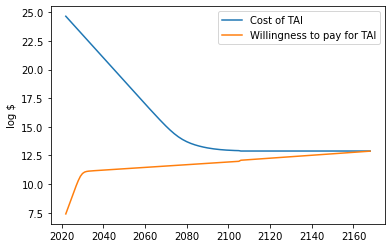

## RUN 6/10000 ##
Diagnostic: tai_flop_size=25.23284035678101, nonscaling_delay=23.213034358307873, algo_doubling_rate=2.5854849452791253, possible_algo_reduction=2.0586443975346262, initial_flops_per_dollar=1.578982042830722e+17, flops_halving_rate=2.424994624179044, max_flops_per_dollar=3.6459809020413657e+24, initial_pay=16203435.04170657, gdp_growth=1.024657482322777, max_gdp_frac=0.025659291479143236, willingness_ramp=1.00826494529188, spend_doubling_time=0.6588867853226518
-
It takes 25.2 log FLOPs (10 septillion) for transformative capabilities.
Every 2.6 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.4 years they get 2x cheaper, to a maximum of 24.6 log FLOPs (one septillion) per $.
We are willing to pay 7.2 log $ (10 million) and this increases by 0.7x per year to a max of 0.0257% of GDP. GDP grows at a rate of 1.025x per year.
If we are 101.0% of the way to paying for TAI, we will ramp

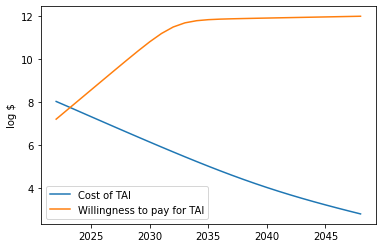

## RUN 7/10000 ##
Diagnostic: tai_flop_size=39.679964898239064, nonscaling_delay=3.9071827053735895, algo_doubling_rate=4.260103398845448, possible_algo_reduction=2.7747962741453307, initial_flops_per_dollar=2.540269162433635e+17, flops_halving_rate=3.023850537852371, max_flops_per_dollar=1.1342408943177935e+27, initial_pay=57365374.800194666, gdp_growth=1.018537405858095, max_gdp_frac=0.0036683348035921946, willingness_ramp=0.7214319438772576, spend_doubling_time=4.734397412619478
-
It takes 39.7 log FLOPs (one million decillion) for transformative capabilities.
Every 4.3 years algorithms get 2x better, with 2.8 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 3.0 years they get 2x cheaper, to a maximum of 27.1 log FLOPs (one octillion) per $.
We are willing to pay 7.8 log $ (10 million) and this increases by 4.7x per year to a max of 0.0037% of GDP. GDP grows at a rate of 1.019x per year.
If we are 72.0% of the way to paying for TAI, we 

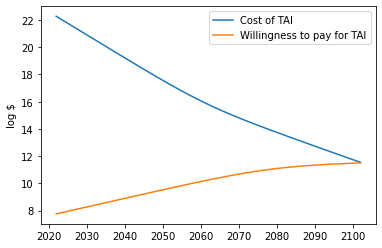

## RUN 8/10000 ##
Diagnostic: tai_flop_size=34.80465916295749, nonscaling_delay=4.437441041255716, algo_doubling_rate=5.491405899823823, possible_algo_reduction=3.764585877417431, initial_flops_per_dollar=1.6118116656705408e+17, flops_halving_rate=4.284155307079558, max_flops_per_dollar=1.551952633391204e+22, initial_pay=54483040.98349897, gdp_growth=1.0232261923904546, max_gdp_frac=0.004130413164813006, willingness_ramp=0.8451159780701052, spend_doubling_time=0.9596228780381238
-
It takes 34.8 log FLOPs (10 decillion) for transformative capabilities.
Every 5.5 years algorithms get 2x better, with 3.8 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 4.3 years they get 2x cheaper, to a maximum of 22.2 log FLOPs (10 sextillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 1.0x per year to a max of 0.0041% of GDP. GDP grows at a rate of 1.023x per year.
If we are 85.0% of the way to paying for TAI, we will ramp to

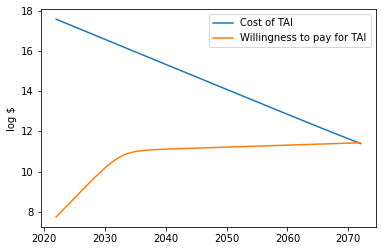

## RUN 9/10000 ##
Diagnostic: tai_flop_size=37.0321249028314, nonscaling_delay=6.7769743270810014, algo_doubling_rate=2.8675521281506557, possible_algo_reduction=3.3647352387798026, initial_flops_per_dollar=1.6051784316204e+17, flops_halving_rate=2.5917727297326882, max_flops_per_dollar=1.456582760657862e+28, initial_pay=36574238.670496814, gdp_growth=1.018647626947942, max_gdp_frac=0.003603514672042346, willingness_ramp=0.9346188596476956, spend_doubling_time=1.099861253906834
-
It takes 37.0 log FLOPs (10 thousand decillion) for transformative capabilities.
Every 2.9 years algorithms get 2x better, with 3.4 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.6 years they get 2x cheaper, to a maximum of 28.2 log FLOPs (10 octillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 1.1x per year to a max of 0.0036% of GDP. GDP grows at a rate of 1.019x per year.
If we are 93.0% of the way to paying for TAI, we will 

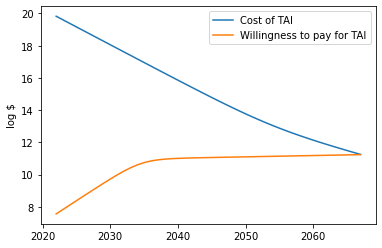

## RUN 10/10000 ##
Diagnostic: tai_flop_size=31.24317324064673, nonscaling_delay=7.352999535409724, algo_doubling_rate=3.101492213300393, possible_algo_reduction=1.1665983258406938, initial_flops_per_dollar=1.4464251940965955e+17, flops_halving_rate=2.5513504992556397, max_flops_per_dollar=1.5885506056225856e+22, initial_pay=18739703.29549608, gdp_growth=1.027043894676793, max_gdp_frac=0.005052612580723526, willingness_ramp=0.7182192548364628, spend_doubling_time=2.5278740244111164
-
It takes 31.2 log FLOPs (10 nonillion) for transformative capabilities.
Every 3.1 years algorithms get 2x better, with 1.2 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.6 years they get 2x cheaper, to a maximum of 22.2 log FLOPs (10 sextillion) per $.
We are willing to pay 7.3 log $ (10 million) and this increases by 2.5x per year to a max of 0.0051% of GDP. GDP grows at a rate of 1.027x per year.
If we are 72.0% of the way to paying for TAI, we will ramp

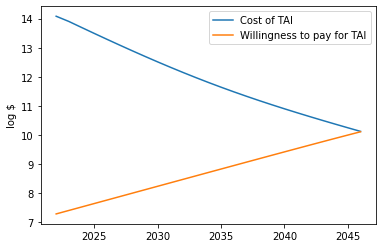

## RUN 11/10000 ##
Diagnostic: tai_flop_size=36.563329109581076, nonscaling_delay=7.05834626981292, algo_doubling_rate=3.213720806668581, possible_algo_reduction=1.7345084848343912, initial_flops_per_dollar=2.0206080304226848e+17, flops_halving_rate=3.4285457228534058, max_flops_per_dollar=9.999108029764735e+24, initial_pay=16959389.110598866, gdp_growth=1.026771423281948, max_gdp_frac=0.00812085536324523, willingness_ramp=0.9138551908462581, spend_doubling_time=0.6966253400549127
-
It takes 36.6 log FLOPs (one thousand decillion) for transformative capabilities.
Every 3.2 years algorithms get 2x better, with 1.7 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.4 years they get 2x cheaper, to a maximum of 25.0 log FLOPs (one septillion) per $.
We are willing to pay 7.2 log $ (10 million) and this increases by 0.7x per year to a max of 0.0081% of GDP. GDP grows at a rate of 1.027x per year.
If we are 91.0% of the way to paying for TAI, we

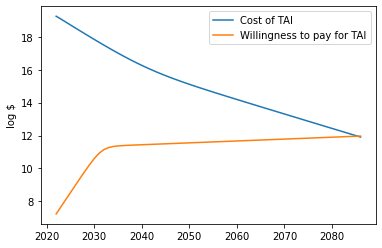

## RUN 12/10000 ##
Diagnostic: tai_flop_size=36.37760871783444, nonscaling_delay=1.8817684031611823, algo_doubling_rate=6.046017651236085, possible_algo_reduction=3.546136009786934, initial_flops_per_dollar=8.16052527144598e+16, flops_halving_rate=2.9194554632376715, max_flops_per_dollar=5.53556980849148e+27, initial_pay=14080184.608825803, gdp_growth=1.033313821432993, max_gdp_frac=0.0026667985746477696, willingness_ramp=0.8951300503870534, spend_doubling_time=2.0370607066318023
-
It takes 36.4 log FLOPs (one thousand decillion) for transformative capabilities.
Every 6.0 years algorithms get 2x better, with 3.5 log reductions possible.
FLOPs start at a cost of 16.9 log FLOPs (10 quadrillion) per $. Every 2.9 years they get 2x cheaper, to a maximum of 27.7 log FLOPs (one octillion) per $.
We are willing to pay 7.1 log $ (10 million) and this increases by 2.0x per year to a max of 0.0027% of GDP. GDP grows at a rate of 1.033x per year.
If we are 90.0% of the way to paying for TAI, we wi

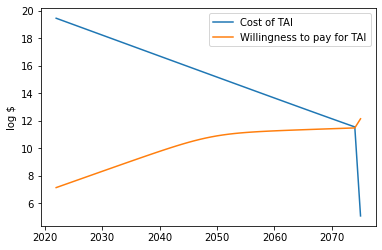

## RUN 13/10000 ##
Diagnostic: tai_flop_size=39.28873053031069, nonscaling_delay=6.669265525735158, algo_doubling_rate=3.0937340084337452, possible_algo_reduction=4.113508273950922, initial_flops_per_dollar=2.4246674349389594e+17, flops_halving_rate=2.931381964379914, max_flops_per_dollar=1.941368117003052e+24, initial_pay=61082121.46871834, gdp_growth=1.0208509592824144, max_gdp_frac=0.003731637147888089, willingness_ramp=0.8951259796469693, spend_doubling_time=0.8855276844456195
-
It takes 39.3 log FLOPs (one million decillion) for transformative capabilities.
Every 3.1 years algorithms get 2x better, with 4.1 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 2.9 years they get 2x cheaper, to a maximum of 24.3 log FLOPs (one septillion) per $.
We are willing to pay 7.8 log $ (10 million) and this increases by 0.9x per year to a max of 0.0037% of GDP. GDP grows at a rate of 1.021x per year.
If we are 90.0% of the way to paying for TAI, we 

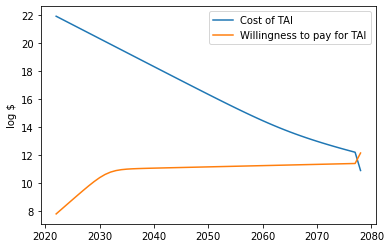

## RUN 14/10000 ##
Diagnostic: tai_flop_size=40.563820672502814, nonscaling_delay=2.2315346353974044, algo_doubling_rate=4.056255962486345, possible_algo_reduction=4.336222561980744, initial_flops_per_dollar=2.123520790662548e+17, flops_halving_rate=3.2739502551417976, max_flops_per_dollar=8.583972775795354e+22, initial_pay=156607568.85380358, gdp_growth=1.0234093858327395, max_gdp_frac=0.001872956175411459, willingness_ramp=0.9348411855952071, spend_doubling_time=0.7326559719322131
-
It takes 40.6 log FLOPs (10 million decillion) for transformative capabilities.
Every 4.1 years algorithms get 2x better, with 4.3 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.3 years they get 2x cheaper, to a maximum of 22.9 log FLOPs (10 sextillion) per $.
We are willing to pay 8.2 log $ (100 million) and this increases by 0.7x per year to a max of 0.0019% of GDP. GDP grows at a rate of 1.023x per year.
If we are 93.0% of the way to paying for TAI, we

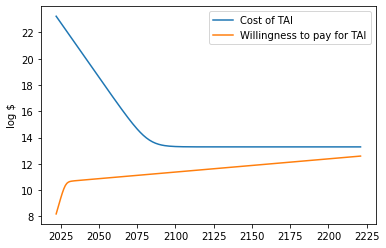

## RUN 15/10000 ##
Diagnostic: tai_flop_size=34.05435585066267, nonscaling_delay=1.7593534367698032, algo_doubling_rate=2.0875191695763524, possible_algo_reduction=2.016767306419754, initial_flops_per_dollar=1.5490443835042195e+17, flops_halving_rate=2.669971680287184, max_flops_per_dollar=1.5657477188681237e+25, initial_pay=9493071.83527523, gdp_growth=1.0184970500152186, max_gdp_frac=0.0033686050586421586, willingness_ramp=0.8252150481791111, spend_doubling_time=0.9175015374177574
-
It takes 34.1 log FLOPs (10 decillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.7 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (10 septillion) per $.
We are willing to pay 7.0 log $ (one million) and this increases by 0.9x per year to a max of 0.0034% of GDP. GDP grows at a rate of 1.018x per year.
If we are 83.0% of the way to paying for TAI, we will ra

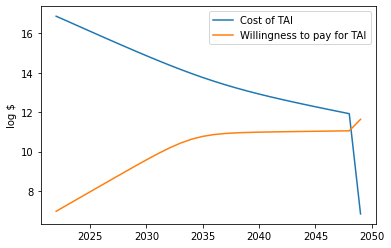

## RUN 16/10000 ##
Diagnostic: tai_flop_size=39.52059058701164, nonscaling_delay=7.227167909695304, algo_doubling_rate=5.411233431577945, possible_algo_reduction=3.8906750174261955, initial_flops_per_dollar=1.4852516824239654e+17, flops_halving_rate=3.8237990622020543, max_flops_per_dollar=1.8217829629337736e+28, initial_pay=71910090.35340355, gdp_growth=1.0266175619949274, max_gdp_frac=0.0028502634243688925, willingness_ramp=0.9708487637848697, spend_doubling_time=0.6803225909192427
-
It takes 39.5 log FLOPs (one million decillion) for transformative capabilities.
Every 5.4 years algorithms get 2x better, with 3.9 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.8 years they get 2x cheaper, to a maximum of 28.3 log FLOPs (10 octillion) per $.
We are willing to pay 7.9 log $ (10 million) and this increases by 0.7x per year to a max of 0.0029% of GDP. GDP grows at a rate of 1.027x per year.
If we are 97.0% of the way to paying for TAI, we

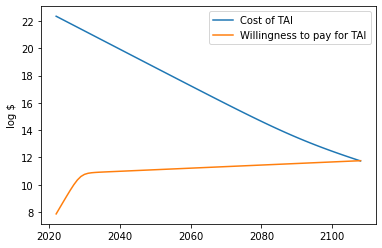

## RUN 17/10000 ##
Diagnostic: tai_flop_size=36.51480266571857, nonscaling_delay=3.419373814485041, algo_doubling_rate=3.6731418759602175, possible_algo_reduction=3.328643265262765, initial_flops_per_dollar=2.849950907632164e+17, flops_halving_rate=3.374868493072591, max_flops_per_dollar=3.37584531931577e+24, initial_pay=10642303.982411722, gdp_growth=1.0190680904087308, max_gdp_frac=0.005289259517109883, willingness_ramp=0.9050184173467876, spend_doubling_time=1.1565807266548047
-
It takes 36.5 log FLOPs (one thousand decillion) for transformative capabilities.
Every 3.7 years algorithms get 2x better, with 3.3 log reductions possible.
FLOPs start at a cost of 17.5 log FLOPs (100 quadrillion) per $. Every 3.4 years they get 2x cheaper, to a maximum of 24.5 log FLOPs (one septillion) per $.
We are willing to pay 7.0 log $ (10 million) and this increases by 1.2x per year to a max of 0.0053% of GDP. GDP grows at a rate of 1.019x per year.
If we are 91.0% of the way to paying for TAI, we 

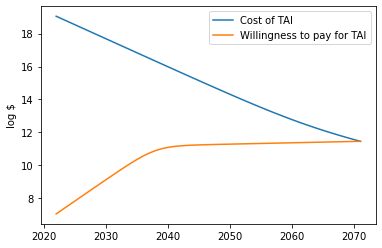

## RUN 18/10000 ##
Diagnostic: tai_flop_size=35.904529836490184, nonscaling_delay=1.1407890972467292, algo_doubling_rate=2.8067158167433806, possible_algo_reduction=3.2079493133373114, initial_flops_per_dollar=3.084620332241902e+17, flops_halving_rate=2.516640633745039, max_flops_per_dollar=6.335207290197943e+24, initial_pay=77072986.89960814, gdp_growth=1.0238482413914196, max_gdp_frac=0.0023304163105613137, willingness_ramp=0.55081424837257, spend_doubling_time=1.3855274579105232
-
It takes 35.9 log FLOPs (100 decillion) for transformative capabilities.
Every 2.8 years algorithms get 2x better, with 3.2 log reductions possible.
FLOPs start at a cost of 17.5 log FLOPs (100 quadrillion) per $. Every 2.5 years they get 2x cheaper, to a maximum of 24.8 log FLOPs (one septillion) per $.
We are willing to pay 7.9 log $ (10 million) and this increases by 1.4x per year to a max of 0.0023% of GDP. GDP grows at a rate of 1.024x per year.
If we are 55.0% of the way to paying for TAI, we will ra

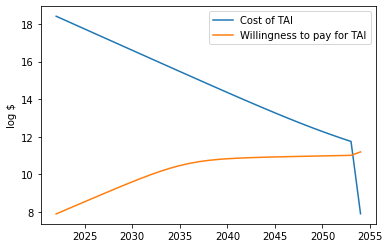

## RUN 19/10000 ##
Diagnostic: tai_flop_size=32.2057915393254, nonscaling_delay=3.4751273241086484, algo_doubling_rate=3.2756125210296383, possible_algo_reduction=0.9419679979255688, initial_flops_per_dollar=8.827642946312963e+16, flops_halving_rate=3.626722289389745, max_flops_per_dollar=2.3817890905246574e+24, initial_pay=27048620.285930537, gdp_growth=1.021069092974758, max_gdp_frac=0.00951963506673206, willingness_ramp=1.0188925554174286, spend_doubling_time=1.3854995306740552
-
It takes 32.2 log FLOPs (100 nonillion) for transformative capabilities.
Every 3.3 years algorithms get 2x better, with 0.9 log reductions possible.
FLOPs start at a cost of 16.9 log FLOPs (10 quadrillion) per $. Every 3.6 years they get 2x cheaper, to a maximum of 24.4 log FLOPs (one septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 1.4x per year to a max of 0.0095% of GDP. GDP grows at a rate of 1.021x per year.
If we are 102.0% of the way to paying for TAI, we will ram

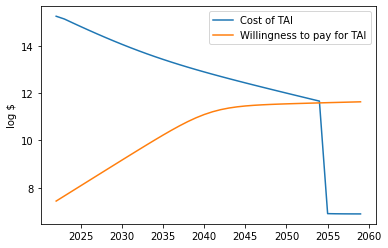

## RUN 20/10000 ##
Diagnostic: tai_flop_size=33.623344698370204, nonscaling_delay=3.535413531937482, algo_doubling_rate=2.654954680654092, possible_algo_reduction=0.8973718179076113, initial_flops_per_dollar=2.039007704460998e+17, flops_halving_rate=2.058781158282897, max_flops_per_dollar=1.095697954568609e+25, initial_pay=22674415.787344307, gdp_growth=1.0278269002630245, max_gdp_frac=0.005218595738989594, willingness_ramp=0.7594122178468108, spend_doubling_time=2.0409102023344583
-
It takes 33.6 log FLOPs (one decillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 0.9 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.1 years they get 2x cheaper, to a maximum of 25.0 log FLOPs (10 septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 2.0x per year to a max of 0.0052% of GDP. GDP grows at a rate of 1.028x per year.
If we are 76.0% of the way to paying for TAI, we will ram

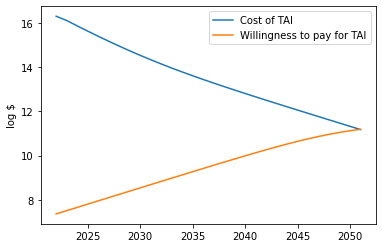

## RUN 21/10000 ##
Diagnostic: tai_flop_size=31.28144550352647, nonscaling_delay=7.564813611739975, algo_doubling_rate=2.6382947182936487, possible_algo_reduction=2.1855489130354555, initial_flops_per_dollar=2.5480648587268832e+17, flops_halving_rate=4.022125727845628, max_flops_per_dollar=1.796199119751854e+21, initial_pay=47608859.2565603, gdp_growth=1.0160040013864533, max_gdp_frac=0.002073969576339291, willingness_ramp=0.7475204757875835, spend_doubling_time=2.689268619270912
-
It takes 31.3 log FLOPs (10 nonillion) for transformative capabilities.
Every 2.6 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 4.0 years they get 2x cheaper, to a maximum of 21.3 log FLOPs (one sextillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 2.7x per year to a max of 0.0021% of GDP. GDP grows at a rate of 1.016x per year.
If we are 75.0% of the way to paying for TAI, we will ramp 

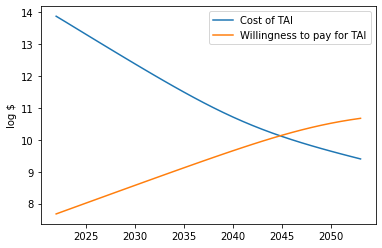

## RUN 22/10000 ##
Diagnostic: tai_flop_size=31.69868964583481, nonscaling_delay=5.042662508743329, algo_doubling_rate=4.649496025418107, possible_algo_reduction=1.9965409802572018, initial_flops_per_dollar=1.842124866611252e+17, flops_halving_rate=2.761289937953208, max_flops_per_dollar=2.9401750487788226e+25, initial_pay=172391529.01949626, gdp_growth=1.0132184040289212, max_gdp_frac=0.00757105773656816, willingness_ramp=1.056842143193082, spend_doubling_time=1.2517747251293816
-
It takes 31.7 log FLOPs (10 nonillion) for transformative capabilities.
Every 4.6 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.8 years they get 2x cheaper, to a maximum of 25.5 log FLOPs (10 septillion) per $.
We are willing to pay 8.2 log $ (100 million) and this increases by 1.3x per year to a max of 0.0076% of GDP. GDP grows at a rate of 1.013x per year.
If we are 106.0% of the way to paying for TAI, we will ramp

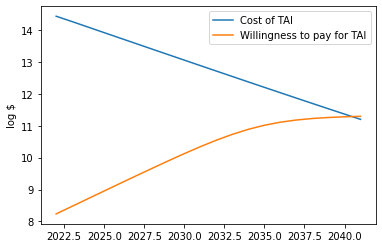

## RUN 23/10000 ##
Diagnostic: tai_flop_size=30.816299267068977, nonscaling_delay=4.260193033424913, algo_doubling_rate=4.2392755537402005, possible_algo_reduction=1.712558626735651, initial_flops_per_dollar=1.2265596926043733e+17, flops_halving_rate=2.9727244004698306, max_flops_per_dollar=2.4694715081559e+21, initial_pay=96278945.5632072, gdp_growth=1.024149667443932, max_gdp_frac=0.018886292759924324, willingness_ramp=0.8304910475607826, spend_doubling_time=0.7423590626645956
-
It takes 30.8 log FLOPs (one nonillion) for transformative capabilities.
Every 4.2 years algorithms get 2x better, with 1.7 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 3.0 years they get 2x cheaper, to a maximum of 21.4 log FLOPs (one sextillion) per $.
We are willing to pay 8.0 log $ (10 million) and this increases by 0.7x per year to a max of 0.0189% of GDP. GDP grows at a rate of 1.024x per year.
If we are 83.0% of the way to paying for TAI, we will ramp 

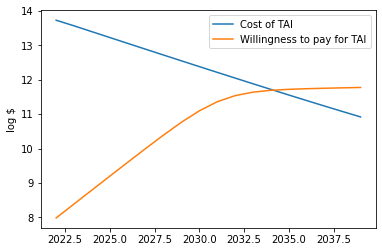

## RUN 24/10000 ##
Diagnostic: tai_flop_size=23.47003341048201, nonscaling_delay=0.6985953439046397, algo_doubling_rate=2.2099220595009514, possible_algo_reduction=1.7768842419658013, initial_flops_per_dollar=2.4016188965452854e+17, flops_halving_rate=3.2751530975291083, max_flops_per_dollar=2.446028364414722e+24, initial_pay=15755594.197280938, gdp_growth=1.0225037546487836, max_gdp_frac=0.005666714234311593, willingness_ramp=0.9394906544707471, spend_doubling_time=0.7171525134325369
-
It takes 23.5 log FLOPs (100 sextillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 3.3 years they get 2x cheaper, to a maximum of 24.4 log FLOPs (one septillion) per $.
We are willing to pay 7.2 log $ (10 million) and this increases by 0.7x per year to a max of 0.0057% of GDP. GDP grows at a rate of 1.023x per year.
If we are 94.0% of the way to paying for TAI, we wil

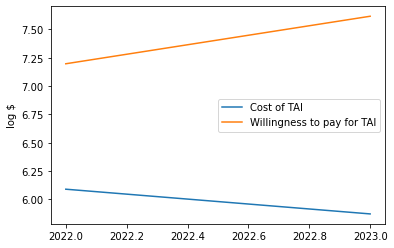

## RUN 25/10000 ##
Diagnostic: tai_flop_size=29.256849842091608, nonscaling_delay=9.408784093812484, algo_doubling_rate=1.5, possible_algo_reduction=2.612863808875568, initial_flops_per_dollar=1.9660224366738506e+17, flops_halving_rate=3.255642783157185, max_flops_per_dollar=4.15749536548507e+22, initial_pay=45282568.113817975, gdp_growth=1.0207483043824106, max_gdp_frac=0.0017039600325576849, willingness_ramp=0.7235815813297752, spend_doubling_time=1.2875269954817297
-
It takes 29.3 log FLOPs (100 octillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 2.6 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.3 years they get 2x cheaper, to a maximum of 22.6 log FLOPs (10 sextillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 1.3x per year to a max of 0.0017% of GDP. GDP grows at a rate of 1.021x per year.
If we are 72.0% of the way to paying for TAI, we will ramp to paying fo

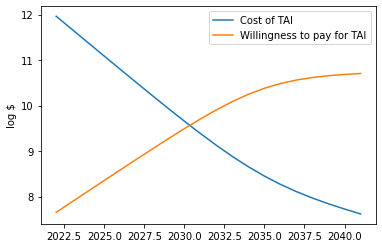

## RUN 26/10000 ##
Diagnostic: tai_flop_size=43.46967519385573, nonscaling_delay=11.654907088896328, algo_doubling_rate=2.1013887985633763, possible_algo_reduction=4.145157190828517, initial_flops_per_dollar=1.9037069257132438e+17, flops_halving_rate=3.2064984891054302, max_flops_per_dollar=1.2790938137411138e+25, initial_pay=26294183.013448562, gdp_growth=1.0234215508270925, max_gdp_frac=0.013090404580984922, willingness_ramp=0.7699573583436323, spend_doubling_time=2.431471099159149
-
It takes 43.5 log FLOPs (10 billion decillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 4.1 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.2 years they get 2x cheaper, to a maximum of 25.1 log FLOPs (10 septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 2.4x per year to a max of 0.0131% of GDP. GDP grows at a rate of 1.023x per year.
If we are 77.0% of the way to paying for TAI, we

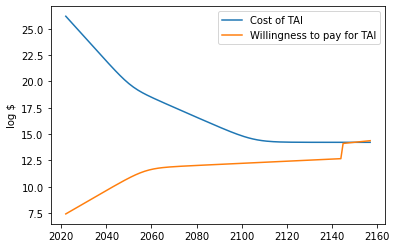

## RUN 27/10000 ##
Diagnostic: tai_flop_size=30.728534164878475, nonscaling_delay=2.8755319881924755, algo_doubling_rate=4.083245609012125, possible_algo_reduction=1.7159491916748986, initial_flops_per_dollar=1.9594219651518832e+17, flops_halving_rate=2.718175119889821, max_flops_per_dollar=2.3450542848542924e+26, initial_pay=48797608.63005285, gdp_growth=1.0201310234686194, max_gdp_frac=0.0034330688116049005, willingness_ramp=0.9552156413995152, spend_doubling_time=2.977194571791851
-
It takes 30.7 log FLOPs (one nonillion) for transformative capabilities.
Every 4.1 years algorithms get 2x better, with 1.7 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.7 years they get 2x cheaper, to a maximum of 26.4 log FLOPs (100 septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 3.0x per year to a max of 0.0034% of GDP. GDP grows at a rate of 1.02x per year.
If we are 96.0% of the way to paying for TAI, we will r

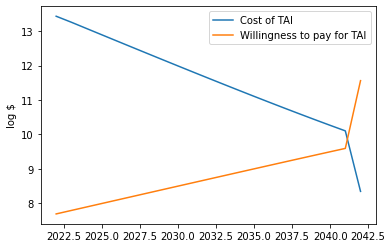

## RUN 28/10000 ##
Diagnostic: tai_flop_size=38.723573948941834, nonscaling_delay=2.1434999919435382, algo_doubling_rate=3.9928163513440085, possible_algo_reduction=5.33355524228213, initial_flops_per_dollar=1.3864560484180981e+17, flops_halving_rate=3.854848262713703, max_flops_per_dollar=1.7780516463072395e+23, initial_pay=90106012.63001941, gdp_growth=1.024959198547398, max_gdp_frac=0.0036937373521197647, willingness_ramp=0.8087448912790581, spend_doubling_time=1.7405413238440393
-
It takes 38.7 log FLOPs (100 thousand decillion) for transformative capabilities.
Every 4.0 years algorithms get 2x better, with 5.3 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 3.9 years they get 2x cheaper, to a maximum of 23.2 log FLOPs (100 sextillion) per $.
We are willing to pay 8.0 log $ (10 million) and this increases by 1.7x per year to a max of 0.0037% of GDP. GDP grows at a rate of 1.025x per year.
If we are 81.0% of the way to paying for TAI, 

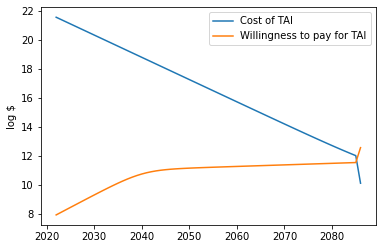

## RUN 29/10000 ##
Diagnostic: tai_flop_size=37.527838963597326, nonscaling_delay=1.1112955675270473, algo_doubling_rate=2.959695753672503, possible_algo_reduction=2.174776490140199, initial_flops_per_dollar=2.129588762564064e+17, flops_halving_rate=2.2055590511546552, max_flops_per_dollar=3.936936456669453e+23, initial_pay=125977508.35957977, gdp_growth=1.0184156263637656, max_gdp_frac=0.012887390296053573, willingness_ramp=0.9093684162605019, spend_doubling_time=1.7955481956949797
-
It takes 37.5 log FLOPs (10 thousand decillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.2 years they get 2x cheaper, to a maximum of 23.6 log FLOPs (100 sextillion) per $.
We are willing to pay 8.1 log $ (100 million) and this increases by 1.8x per year to a max of 0.0129% of GDP. GDP grows at a rate of 1.018x per year.
If we are 91.0% of the way to paying for TAI, 

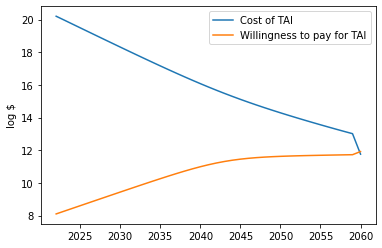

## RUN 30/10000 ##
Diagnostic: tai_flop_size=38.21150937792163, nonscaling_delay=10.96661344244438, algo_doubling_rate=4.170599037315879, possible_algo_reduction=5.14464510780061, initial_flops_per_dollar=7.993187094438485e+16, flops_halving_rate=2.483579691179805, max_flops_per_dollar=1.2445716750399217e+25, initial_pay=59443630.94367467, gdp_growth=1.0299234090741276, max_gdp_frac=0.004093423480274795, willingness_ramp=1.060699277764618, spend_doubling_time=1.1986358970247157
-
It takes 38.2 log FLOPs (100 thousand decillion) for transformative capabilities.
Every 4.2 years algorithms get 2x better, with 5.1 log reductions possible.
FLOPs start at a cost of 16.9 log FLOPs (10 quadrillion) per $. Every 2.5 years they get 2x cheaper, to a maximum of 25.1 log FLOPs (10 septillion) per $.
We are willing to pay 7.8 log $ (10 million) and this increases by 1.2x per year to a max of 0.0041% of GDP. GDP grows at a rate of 1.03x per year.
If we are 106.0% of the way to paying for TAI, we will

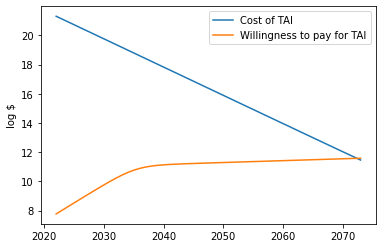

## RUN 101/10000 ##
## RUN 201/10000 ##
## RUN 301/10000 ##
## RUN 401/10000 ##
## RUN 501/10000 ##
## RUN 601/10000 ##
## RUN 701/10000 ##
## RUN 801/10000 ##
## RUN 901/10000 ##
## RUN 1001/10000 ##
## RUN 1101/10000 ##
## RUN 1201/10000 ##
## RUN 1301/10000 ##
## RUN 1401/10000 ##
## RUN 1501/10000 ##
## RUN 1601/10000 ##
## RUN 1701/10000 ##
## RUN 1801/10000 ##
## RUN 1901/10000 ##
## RUN 2001/10000 ##
## RUN 2101/10000 ##
## RUN 2201/10000 ##
## RUN 2301/10000 ##
## RUN 2401/10000 ##
## RUN 2501/10000 ##
## RUN 2601/10000 ##
## RUN 2701/10000 ##
## RUN 2801/10000 ##
## RUN 2901/10000 ##
## RUN 3001/10000 ##
## RUN 3101/10000 ##
## RUN 3201/10000 ##
## RUN 3301/10000 ##
## RUN 3401/10000 ##
## RUN 3501/10000 ##
## RUN 3601/10000 ##
## RUN 3701/10000 ##
## RUN 3801/10000 ##
## RUN 3901/10000 ##
## RUN 4001/10000 ##
## RUN 4101/10000 ##
## RUN 4201/10000 ##
## RUN 4301/10000 ##
## RUN 4401/10000 ##
## RUN 4501/10000 ##
## RUN 4601/10000 ##
## RUN 4701/10000 ##
## RUN 4801/10000 ##
#

In [417]:
tai_years = []
tai_flop_size_log_ = []
plt.ioff()
print('Running')

for r in range(RUNS):
    print_diagnostic = r < 30
    if print_diagnostic or r % 100 == 0 or r >= RUNS - 1:
        print('## RUN {}/{} ##'.format(r + 1, RUNS))
    if print_diagnostic:
        cost_of_tai_collector = []
        willingness_collector = []
    
    tai_flop_size_ = sample(tai_flop_size)
    tai_flop_size_log_.append(tai_flop_size_)
    algo_doubling_rate_ = sample(algo_doubling_rate)
    possible_algo_reduction_ = possible_algo_reduction_fn(sample(min_reduction),
                                                          sample(max_reduction),
                                                          tai_flop_size_)
    initial_flops_per_dollar_ = 10 ** sample(initial_flops_per_dollar)
    flops_halving_rate_ = sample(flops_halving_rate)
    max_flops_per_dollar_ = 10 ** sample(max_flops_per_dollar)
    initial_pay_ = 10 ** sample(initial_pay)
    gdp_growth_ = sample(gdp_growth)
    max_gdp_frac_ = sample(max_gdp_frac)
    willingness_ramp_ = sample(willingness_ramp)
    spend_doubling_time_ = sample(spend_doubling_time)
    nonscaling_delay_ = sample(nonscaling_delay)
    initial_chance_of_nonscaling_issue_ = initial_chance_of_nonscaling_issue
    final_chance_of_nonscaling_issue_ = final_chance_of_nonscaling_issue
    
    if print_diagnostic:
        diagnostic = 'Diagnostic: tai_flop_size={}, nonscaling_delay={}, algo_doubling_rate={}, '
        diagnostic += 'possible_algo_reduction={}, initial_flops_per_dollar={}, flops_halving_rate={}, '
        diagnostic += 'max_flops_per_dollar={}, initial_pay={}, gdp_growth={}, max_gdp_frac={}, '
        diagnostic += 'willingness_ramp={}, spend_doubling_time={}'
        print(diagnostic.format(tai_flop_size_, nonscaling_delay_, algo_doubling_rate_,
                                possible_algo_reduction_, initial_flops_per_dollar_, flops_halving_rate_,
                                max_flops_per_dollar_, initial_pay_, gdp_growth_, max_gdp_frac_,
                                willingness_ramp_, spend_doubling_time_))
        print('-')

        print('It takes {} log FLOPs ({}) for transformative capabilities.'.format(np.round(tai_flop_size_, 1),
                                                                                   numerize(tai_flop_size_)))
        print('Every {} years algorithms get 2x better, with {} log reductions possible.'.format(np.round(algo_doubling_rate_, 1),
                                                                                                 np.round(possible_algo_reduction_, 1)))
        print(('FLOPs start at a cost of {} log FLOPs ({}) per $. Every {} years they get ' +
               '2x cheaper, to a maximum of {} log FLOPs ({}) per $.').format(np.round(math.log10(initial_flops_per_dollar_), 1),
                                                                              numerize(math.log10(initial_flops_per_dollar_)),
                                                                              np.round(flops_halving_rate_, 1),
                                                                              np.round(math.log10(max_flops_per_dollar_), 1),
                                                                              numerize(math.log10(max_flops_per_dollar_))))
        print(('We are willing to pay {} log $ ({}) and this increases by {}x per year to a max of {}% of GDP. ' +
               'GDP grows at a rate of {}x per year.').format(np.round(math.log10(initial_pay_), 1),
                                                              numerize(math.log10(initial_pay_)),
                                                              np.round(spend_doubling_time_, 1),
                                                              np.round(max_gdp_frac_, 4),
                                                              np.round(gdp_growth_, 3)))
        print('If we are {}% of the way to paying for TAI, we will ramp to paying for TAI.'.format(np.round(willingness_ramp_ * 100)))
        print(('If a non-scaling delay happens, it will take an additional {} years to produce TAI due' +
               ' to issues unrelated to scaling FLOP').format(np.round(nonscaling_delay_, 1)))
        print('---')
    
    tai_created = False
    is_nonscaling_issue = None
    recursive = False
    for y in years:
        if not tai_created:  
            flops_needed_ = flops_needed(initial_flops=10 ** tai_flop_size_,
                                         doubling_rate=algo_doubling_rate_,
                                         possible_reduction=10 ** possible_algo_reduction_,
                                         year=(y - CURRENT_YEAR))
            flops_per_dollar_ = flops_per_dollar(initial_flops_per_dollar=initial_flops_per_dollar_,
                                                 max_flops_per_dollar=max_flops_per_dollar_,
                                                 halving_rate=flops_halving_rate_,
                                                 year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200:
                flops_needed_ = int(flops_needed_)
                flops_per_dollar_ = int(flops_per_dollar_)
                
            cost_of_tai_ = flops_needed_ / flops_per_dollar_
            willingness_ = willingness_to_pay(initial_gdp=initial_gdp,
                                              gdp_growth=gdp_growth_,
                                              initial_pay=initial_pay_,
                                              spend_doubling_time=spend_doubling_time_,
                                              max_gdp_frac=max_gdp_frac_,
                                              year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200:
                willingness_ = int(willingness_)
            if willingness_ > 10 ** 200:
                flops_per_dollar_ = int(flops_per_dollar_)
            
            total_compute_ = willingness_ * flops_per_dollar_
            p_recursive = p_rapid_recursive_self_improvement(flops_needed_,
                                                             total_compute_,
                                                             base_p_recursive,
                                                             recursive_curve_steepness,
                                                             recursive_curve_inflection)
            p_recursive = p_recursive / 8 # Attempt to turn CDF into PDF (approximation)
            
            cost_of_tai_collector.append(cost_of_tai_)
            willingness_collector.append(willingness_)
            
            if print_diagnostic:
                out_str = ('Year: {} - {} max log FLOP ({}) available - TAI takes {} log FLOP ({}) - ' +
                           'log $ {} to buy TAI ({}) vs. willingness to pay log $ {} ({}) - {} log FLOPS per $ ({})')
                print(out_str.format(y,
                                     np.round(math.log10(total_compute_), 1),
                                     numerize(math.log10(total_compute_)),
                                     np.round(math.log10(flops_needed_), 1),
                                     numerize(math.log10(flops_needed_)),
                                     np.round(math.log10(cost_of_tai_), 1),
                                     numerize(math.log10(cost_of_tai_)),
                                     np.round(math.log10(willingness_), 1),
                                     numerize(math.log10(willingness_)),
                                     np.round(math.log10(flops_per_dollar_), 1),
                                     numerize(math.log10(flops_per_dollar_))))
            
            if cost_of_tai_ * willingness_ramp_ <= willingness_:
                if is_nonscaling_issue is None:
                    p_nonscaling_delay_ = p_nonscaling_delay(initial_chance_of_nonscaling_issue,
                                                             final_chance_of_nonscaling_issue,
                                                             year=y,
                                                             max_year=nonscaling_issue_bottom_year)
                    r_ = random.random()
                    is_nonscaling_issue = r_ < p_nonscaling_delay_
                    nonscaling_countdown = nonscaling_delay_
                    if print_diagnostic:
                        print('-- {} p_nonscaling_issue={} r_={}'.format('Nonscaling delay occured' if is_nonscaling_issue else 'Nonscaling issue did not occur',
                                                                         np.round(p_nonscaling_delay_, 4),
                                                                         np.round(r_, 4)))
                
                if not is_nonscaling_issue or nonscaling_countdown <= 0.1:
                    if print_diagnostic:
                        print('--- /!\ TAI CREATED in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    tai_years.append(y)
                    tai_created = True
                else:
                    if print_diagnostic:
                        print('/!\ FLOPs for TAI sufficient but needs {} more years to solve non-scaling issues'.format(np.round(nonscaling_countdown, 1)))
                    nonscaling_countdown -= 1
            
            r_ = random.random()
            if not tai_created and not is_nonscaling_issue and not recursive and r_ < p_recursive:
                flops_halving_rate__ = sample(recursive_flops_halving_rate)
                flops_halving_rate_ = flops_halving_rate__ if flops_halving_rate__ < flops_halving_rate_ else flops_halving_rate_
                algo_doubling_rate__ = sample(recursive_algo_doubling_rate)
                algo_doubling_rate_ = algo_doubling_rate__ if algo_doubling_rate__ < algo_doubling_rate_ else algo_doubling_rate_
                spend_doubling_time__ = sample(recursive_spend_doubling_time)
                spend_doubling_time_ = spend_doubling_time__ if spend_doubling_time__ < spend_doubling_time_ else spend_doubling_time_
                gdp_growth__ = sample(recursive_gdp_growth)
                gdp_growth_ = gdp_growth__ if gdp_growth__ > gdp_growth_ else gdp_growth_
                initial_chance_of_nonscaling_issue_ = recursive_initial_chance_of_nonscaling_issue
                final_chance_of_nonscaling_issue_ = recursive_final_chance_of_nonscaling_issue
                recursive = True
                # TODO: fix issue where this changes the variables as of 2022 rather than as of the time of the rapid recursion

                if print_diagnostic:
                    print(('--- rapid recursive loop (ratio={} p={}, r_={}) - set flops_having_rate={}, ' +
                           'algo_doubling_rate={} spend_doubling_time={}, gdp_growth={}, initial_chance_of_nonscaling_issue={} ' +
                           'final_chance_of_nonscaling_issue={}').format(total_compute_ / flops_needed_,
                                                                         p_recursive,
                                                                         r_,
                                                                         flops_halving_rate_,
                                                                         algo_doubling_rate_,
                                                                         spend_doubling_time_,
                                                                         gdp_growth_,
                                                                         initial_chance_of_nonscaling_issue,
                                                                         final_chance_of_nonscaling_issue))
                if event_occurs(p_recursive_creates_tai_instantly):
                    if print_diagnostic:
                        print('--- /!\ RRSI LOOP CREATES TAI in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    tai_years.append(y)
                    tai_created = True
                        
            elif not tai_created and not is_nonscaling_issue and not recursive and print_diagnostic:
                print('--- no rapid recursive loop (ratio={}, p={}, r_={})'.format(round(total_compute_ / flops_needed_, 3),
                                                                                   p_recursive,
                                                                                   r_))
                
    if not tai_created:
        if print_diagnostic:
            print('--- :/ TAI NOT CREATED BEFORE {}'.format(MAX_YEAR + 1))
            plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
        tai_years.append(MAX_YEAR + 1)


In [418]:
out = get_percentiles(tai_years)
[str(o[0]) + '%: ' + (str(int(o[1])) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR)) for o in out.items()]

# NOTE: Ajeya's numbers should output something very close to:
# '5%': 2027,
# '10%: 2031',
# '20%: 2037',
# '30%: 2042',
# '40%: 2047',
# '50%: 2053',
# '60%: 2061',
# '70%: 2073',
# '80%: >2100',
# '90%: >2100',
# '95%: >2100'

# My latest numbers (2022 Jul 26 12:23AM CT):
#['5%: 2029',
# '10%: 2032',
# '20%: 2038',
# '30%: 2044',
# '40%: 2050',
# '50%: 2057',
# '60%: 2065',
# '70%: 2078',
# '80%: 2101',
# '90%: 2218',
# '95%: >2222']


['5%: 2029',
 '10%: 2032',
 '20%: 2038',
 '30%: 2044',
 '40%: 2050',
 '50%: 2057',
 '60%: 2066',
 '70%: 2078',
 '80%: 2102',
 '90%: >2222',
 '95%: >2222']

In [419]:
[str(o[0]) + '%: ' + (str(int(o[1]) - CURRENT_YEAR) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR - CURRENT_YEAR)) + ' years from now' for o in out.items()]


['5%: 7 years from now',
 '10%: 10 years from now',
 '20%: 16 years from now',
 '30%: 22 years from now',
 '40%: 28 years from now',
 '50%: 35 years from now',
 '60%: 44 years from now',
 '70%: 56 years from now',
 '80%: 80 years from now',
 '90%: >200 years from now',
 '95%: >200 years from now']

In [420]:
def print_chance_tai_by_year(data, year_target):
    return '{}% chance of TAI by EOY {}'.format(int(np.round(sum([1 if y <= year_target else 0 for y in data]) / len(data) * 100, 0)),
                                                year_target)
    
print('## Within <2 years')
print_chance_tai_by_year(tai_years, 2023)


## Within <2 years


'0% chance of TAI by EOY 2023'

In [421]:
print_chance_tai_by_year(tai_years, 2024)

'1% chance of TAI by EOY 2024'

In [422]:
print_chance_tai_by_year(tai_years, 2025)

'2% chance of TAI by EOY 2025'

In [423]:
print('## Within 5 years')
print_chance_tai_by_year(tai_years, 2027)

## Within 5 years


'4% chance of TAI by EOY 2027'

In [424]:
print_chance_tai_by_year(tai_years, 2029)

'6% chance of TAI by EOY 2029'

In [425]:
print_chance_tai_by_year(tai_years, 2030)

'8% chance of TAI by EOY 2030'

In [426]:
print('## Within 10 years')
print_chance_tai_by_year(tai_years, 2032)

## Within 10 years


'11% chance of TAI by EOY 2032'

In [427]:
# Holden benchmarks from https://www.cold-takes.com/biological-anchors-is-about-bounding-not-pinpointing-ai-timelines/#bio-anchors-as-a-way-of-bounding-ai-timelines
print('## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)')
print_chance_tai_by_year(tai_years, 2036)


## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)


'17% chance of TAI by EOY 2036'

In [428]:
print('## Within 15 years')
print_chance_tai_by_year(tai_years, 2037)

## Within 15 years


'19% chance of TAI by EOY 2037'

In [448]:
print_chance_tai_by_year(tai_years, 2040)

'24% chance of TAI by EOY 2040'

In [430]:
print('## Within 20 years')
print_chance_tai_by_year(tai_years, 2042)

## Within 20 years


'28% chance of TAI by EOY 2042'

In [431]:
print('## Within 25 years')
print_chance_tai_by_year(tai_years, 2047)

## Within 25 years


'36% chance of TAI by EOY 2047'

In [449]:
print_chance_tai_by_year(tai_years, 2050)

'40% chance of TAI by EOY 2050'

In [450]:
print_chance_tai_by_year(tai_years, 2060)

'54% chance of TAI by EOY 2060'

In [434]:
print('## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)')
print_chance_tai_by_year(tai_years, 2060)

## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)


'54% chance of TAI by EOY 2060'

In [436]:
print('## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)')
print_chance_tai_by_year(tai_years, 2070)

## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)


'64% chance of TAI by EOY 2070'

In [437]:
print('## Within 50 years')
print_chance_tai_by_year(tai_years, 2072)

## Within 50 years


'66% chance of TAI by EOY 2072'

In [438]:
print('## Within my personal expected lifespan')
print_chance_tai_by_year(tai_years, 2078)

## Within my personal expected lifespan


'70% chance of TAI by EOY 2078'

In [439]:
print('## Within 75 years')
print_chance_tai_by_year(tai_years, 2097)

## Within 75 years


'79% chance of TAI by EOY 2097'

In [440]:
print('## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)')
print_chance_tai_by_year(tai_years, 2100)

## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)


'80% chance of TAI by EOY 2100'

In [441]:
print('## Within 100 years')
print_chance_tai_by_year(tai_years, 2122)

## Within 100 years


'83% chance of TAI by EOY 2122'

In [442]:
print('## Within 200 years')
print_chance_tai_by_year(tai_years, 2222)

## Within 200 years


'89% chance of TAI by EOY 2222'

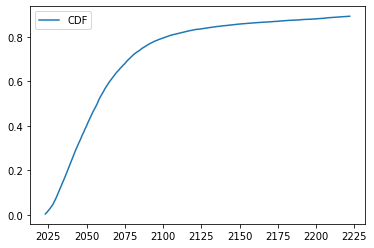

In [443]:
tai_years_ = np.array([MAX_YEAR + 1 if t > MAX_YEAR else t for t in tai_years])
count, bins_count = np.histogram(tai_years_, bins=(MAX_YEAR - CURRENT_YEAR))
pdf = count / sum(count)
cdf = np.cumsum(pdf)
bins = np.round(np.array([b for b in bins_count[1:] if b <= MAX_YEAR]))

plt.plot(bins, cdf[:len(bins)], label='CDF')
plt.legend()

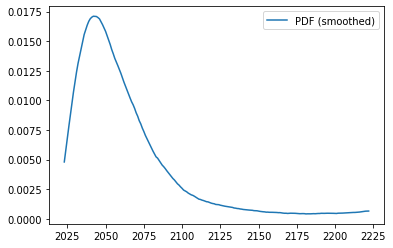

In [444]:
pdf_smoothed = savitzky_golay(pdf[:len(bins)], 51, 3) # window size 51, polynomial order 3
plt.plot(bins, pdf_smoothed, label='PDF (smoothed)')
plt.legend()
plt.show()

In [445]:
cdf[:len(bins)]

array([0.0048, 0.0112, 0.0196, 0.0282, 0.0383, 0.0479, 0.0616, 0.0756,
       0.0917, 0.1076, 0.1237, 0.1402, 0.1573, 0.1728, 0.1902, 0.2076,
       0.2246, 0.2421, 0.259 , 0.2778, 0.2943, 0.309 , 0.3253, 0.3395,
       0.3566, 0.3706, 0.3867, 0.4008, 0.4171, 0.4321, 0.4467, 0.4613,
       0.474 , 0.4871, 0.501 , 0.5176, 0.531 , 0.5427, 0.5544, 0.5675,
       0.5786, 0.5889, 0.5991, 0.6084, 0.6176, 0.6263, 0.6356, 0.6438,
       0.6508, 0.6591, 0.6665, 0.6735, 0.6801, 0.6887, 0.6962, 0.7028,
       0.7093, 0.7157, 0.7226, 0.7278, 0.7326, 0.7368, 0.7414, 0.7477,
       0.7518, 0.7564, 0.7605, 0.7645, 0.7689, 0.7724, 0.7757, 0.7791,
       0.7826, 0.7848, 0.788 , 0.7905, 0.793 , 0.7957, 0.7979, 0.8008,
       0.8032, 0.8054, 0.8077, 0.8094, 0.8106, 0.8128, 0.8144, 0.8166,
       0.8179, 0.8197, 0.8215, 0.8229, 0.8247, 0.8263, 0.8277, 0.8291,
       0.8306, 0.8318, 0.8334, 0.8345, 0.8352, 0.8367, 0.8374, 0.8386,
       0.8398, 0.8406, 0.8421, 0.8429, 0.844 , 0.845 , 0.8457, 0.8466,
      

In [446]:
pdf[:len(bins)]

array([0.0048, 0.0064, 0.0084, 0.0086, 0.0101, 0.0096, 0.0137, 0.014 ,
       0.0161, 0.0159, 0.0161, 0.0165, 0.0171, 0.0155, 0.0174, 0.0174,
       0.017 , 0.0175, 0.0169, 0.0188, 0.0165, 0.0147, 0.0163, 0.0142,
       0.0171, 0.014 , 0.0161, 0.0141, 0.0163, 0.015 , 0.0146, 0.0146,
       0.0127, 0.0131, 0.0139, 0.0166, 0.0134, 0.0117, 0.0117, 0.0131,
       0.0111, 0.0103, 0.0102, 0.0093, 0.0092, 0.0087, 0.0093, 0.0082,
       0.007 , 0.0083, 0.0074, 0.007 , 0.0066, 0.0086, 0.0075, 0.0066,
       0.0065, 0.0064, 0.0069, 0.0052, 0.0048, 0.0042, 0.0046, 0.0063,
       0.0041, 0.0046, 0.0041, 0.004 , 0.0044, 0.0035, 0.0033, 0.0034,
       0.0035, 0.0022, 0.0032, 0.0025, 0.0025, 0.0027, 0.0022, 0.0029,
       0.0024, 0.0022, 0.0023, 0.0017, 0.0012, 0.0022, 0.0016, 0.0022,
       0.0013, 0.0018, 0.0018, 0.0014, 0.0018, 0.0016, 0.0014, 0.0014,
       0.0015, 0.0012, 0.0016, 0.0011, 0.0007, 0.0015, 0.0007, 0.0012,
       0.0012, 0.0008, 0.0015, 0.0008, 0.0011, 0.001 , 0.0007, 0.0009,
      

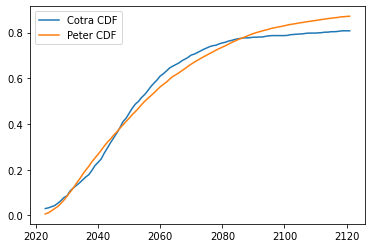

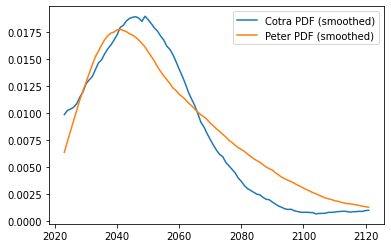

In [447]:
ajeya_cdf = [0.03 , 0.033, 0.038, 0.043, 0.053, 0.064, 0.078, 0.086, 0.107, 0.12 , 0.131, 0.142, 0.155, 0.168, 0.178,
             0.197, 0.218, 0.232, 0.247, 0.273, 0.295, 0.318, 0.339, 0.36 , 0.383, 0.41 , 0.425, 0.447, 0.469, 0.487,
             0.499, 0.516, 0.529, 0.546, 0.564, 0.579, 0.593, 0.61 , 0.62 , 0.632, 0.645, 0.653, 0.66 , 0.667, 0.677,
             0.684, 0.692, 0.702, 0.706, 0.713, 0.72 , 0.727, 0.733, 0.739, 0.743, 0.745, 0.751, 0.755, 0.758, 0.763,
             0.766, 0.77 , 0.773, 0.775, 0.777, 0.777, 0.778, 0.78 , 0.78 , 0.781, 0.781, 0.784, 0.786, 0.787, 0.787,
             0.787, 0.787, 0.787, 0.788, 0.791, 0.792, 0.793, 0.794, 0.795, 0.797, 0.798, 0.798, 0.798, 0.799, 0.8  ,
             0.802, 0.802, 0.804, 0.804, 0.805, 0.807, 0.808, 0.808, 0.808]
ajeya_pdf = np.append(np.array(ajeya_cdf[0]), np.diff(ajeya_cdf[:len(bins)]))
ajeya_pdf_smoothed = savitzky_golay(ajeya_pdf[:len(bins)], 51, 3)

peter_cdf = [0.0065, 0.0114, 0.0202, 0.0297, 0.0387, 0.0523, 0.0667, 0.0845,
       0.1022, 0.119 , 0.1403, 0.1584, 0.179 , 0.1977, 0.2148, 0.2347,
       0.251 , 0.2677, 0.285 , 0.3037, 0.3203, 0.3343, 0.351 , 0.365 ,
       0.3814, 0.3959, 0.4112, 0.4251, 0.4413, 0.4543, 0.469 , 0.4848,
       0.4993, 0.5118, 0.524 , 0.5363, 0.5497, 0.5629, 0.5734, 0.5835,
       0.5959, 0.6075, 0.6154, 0.6239, 0.6335, 0.6431, 0.6529, 0.6623,
       0.6707, 0.6789, 0.6869, 0.6944, 0.7018, 0.7091, 0.7158, 0.7236,
       0.7302, 0.7365, 0.7426, 0.7496, 0.757 , 0.7627, 0.7693, 0.7744,
       0.7798, 0.7851, 0.7908, 0.7959, 0.8002, 0.8042, 0.808 , 0.8117,
       0.8152, 0.8191, 0.8216, 0.8248, 0.8272, 0.83  , 0.8333, 0.836 ,
       0.8381, 0.8403, 0.8428, 0.8447, 0.8473, 0.849 , 0.8513, 0.8531,
       0.8552, 0.8574, 0.8593, 0.8615, 0.863 , 0.8649, 0.866 , 0.8685,
       0.8696, 0.8709, 0.8717, 0.8729, 0.8742, 0.875 , 0.8762, 0.877 ,
       0.8776, 0.8785, 0.8795, 0.8805, 0.8812, 0.8818, 0.8826, 0.8835,
       0.8847, 0.8853, 0.8858, 0.8869, 0.8874, 0.8876, 0.8882, 0.8888,
       0.8896, 0.8904, 0.891 , 0.8916, 0.8922, 0.8925, 0.8932, 0.8938,
       0.8943, 0.895 , 0.8959, 0.8967, 0.8974, 0.898 , 0.899 , 0.8996,
       0.9   , 0.9004, 0.9006, 0.9011, 0.9015, 0.9023, 0.9029, 0.9032,
       0.9039, 0.9041, 0.9045, 0.9048, 0.9052, 0.9057, 0.9061, 0.9064,
       0.9067, 0.907 , 0.9073, 0.9076, 0.908 , 0.9086, 0.9092, 0.91  ,
       0.9102, 0.9106, 0.9107, 0.911 , 0.9114, 0.9117, 0.9123, 0.9128,
       0.913 , 0.9133, 0.9136, 0.914 , 0.9143, 0.9145, 0.9151, 0.9155,
       0.9156, 0.916 , 0.9164, 0.9167, 0.9172, 0.9175, 0.918 , 0.9183,
       0.9189, 0.9195, 0.92  , 0.9202, 0.9204, 0.9206, 0.9208, 0.9212,
       0.9217, 0.9221, 0.9224, 0.9231, 0.9234, 0.9237, 0.9244]
peter_pdf = np.append(np.array(peter_cdf[0]), np.diff(peter_cdf[:len(bins)]))
peter_pdf_smoothed = savitzky_golay(peter_pdf[:len(bins)], 51, 3)

plt.plot(bins[:99], ajeya_cdf[:99], label='Cotra CDF')
plt.plot(bins[:99], peter_cdf[:99], label='Peter CDF')
plt.legend()
plt.show()

plt.plot(bins[:99], ajeya_pdf_smoothed[:99], label='Cotra PDF (smoothed)')
plt.plot(bins[:99], peter_pdf_smoothed[:99], label='Peter PDF (smoothed)')
plt.legend()
plt.show()